

```
# Выбран кодовый формат
```



[Ссылка на  Colab](https://colab.research.google.com/drive/1-ANBfrM0By2WqfWSfGdEkzeonHWOTcro?usp=sharing)

# Промышленность

Чтобы оптимизировать производственные расходы, металлургический комбинат «Стальная птица» решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава.

**Задача** — построить модель, которая будет предсказывать температуру сплава.

Заказчик хочет использовать разработанную модель для имитации технологического процесса. Изучите его, прежде чем генерировать новые признаки.

**Описание данных**

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:

* `steel.data_arc` — данные об электродах;
* `steel.data_bulk` — данные об объёме сыпучих материалов;
* `steel.data_bulk_time` — данные о времени подачи сыпучих материалов;
* `steel.data_gas` — данные о продувке сплава газом;
* `steel.data_temp` — данные об измерениях температуры;
* `steel.data_wire` — данные об объёме проволочных материалов;
* `steel.data_wire_time` — данные о времени подачи проволочных материалов.

### Установка библиотек

In [ ]:
!pip install -q catboost optuna

### Ипорт библиотек

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import psycopg2
from datetime import time

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor, Pool

import optuna

import
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

### Объявление констант

In [ ]:
RANDOM_STATE = 161023

In [ ]:
sns.set_style("whitegrid")

### Объявление функций

In [ ]:
# Функция приводит колонки датафрейма к стандарту PEP-8
def column_pep(df):
  df.columns = (df.columns
                .str.replace('(?<=[a-z])(?=[A-Z])|([" "])', '_', regex=True)
                .str.lower()
             )

In [ ]:
# функция выводит информацию о датафрейме:
#
def fn_eda(df):
  column_pep(df) # приводит коолнки датафрейма к стандарту PEP-8
  display(df.head())      # выводит первые 5 строк
  display('')
  display('----------------------------------------------------')
  display('--------------Проверка на дубликаты-----------------')
  display(f'Количество дубликатов в датафрейме - {df.duplicated().sum()}')
  display('')
  display('----------------------------------------------------')
  display('--------------Проверка на пропуски------------------')
  display(f'Таблица с признаками и пропускими в ник')
  display(pd.DataFrame((df.isna().mean()*100).sort_values(ascending=False), columns=['% проаусков']))
  display('')
  display('----------------------------------------------------')
  display('--------------Инфомация о датафрейме----------------')
  display(df.info())
  display('')
  display('----------------------------------------------------')
  display('--------------Описательные статистики---------------')
  display(df.describe().T)
  display('')
  display('')
  if df.duplicated().sum() == 0:
    display('В датафрейме нет явных дубликатов')
  else:
    display(f'В датафрейме {df.duplicated().sum()} дублика/тов')

In [ ]:
# Функция на вход принимает datetime.time на выходе выдает ps.Series с количеством секунд с начала суток
# на выходе выдает ps.Series с количеством секунд с начала суток
def datetime_to_second(col):
  ser = []
  try:
    for i in range(len(col)):
      ser.append((col[i].hour * 3600) + # часы в секунды
                (col[i].minute * 60) + # минуты в секунды
                  col[i].second)
  except:
    for i in range(1, len(col)):
      ser.append((col[i].hour * 3600) + # часы в секунды
                (col[i].minute * 60) + # минуты в секунды
                  col[i].second)
  return pd.Series(ser)

In [ ]:
# Функция выводит график гистограммы и боксплот на вход принимает
# датафрейм и строку с названием признака(колонки)
def gist_box(df, col):
  fig, (ax_box, ax_hist) = plt.subplots(2,# две строки в сетке подграфиков,
                                     figsize=(12,8),
                                    sharex = True, # единая шкала по оси x и
                                    gridspec_kw = {'height_ratios': (.15, .85)}) # пропорция 15/85 по высоте

# затем создадим графики, указав через параметр ax, в какой подграфик поместить каждый из них
  sns.boxplot(x = df[col], ax = ax_box)
  sns.histplot(x = df[col], ax = ax_hist, bins = 50, kde = True)

# добавим подписи к каждому из графиков через метод .set()
  ax_box.set(title= f'{col}')
  ax_box.set(xlabel = '') # пустые кавычки удаляют подпись
  ax_hist.set(xlabel = f'{col}')
  ax_hist.set(ylabel = 'count')

# выведем результат
  plt.show();

In [ ]:
# Создание ПНС
class Net(nn.Module):

    def __init__(self,
                 n_in_neurons,
                 n_hidden_neurons_1,
                 n_hidden_neurons_2,
                 n_out_neurons,
                 drop_out):

            super(Net, self).__init__()

            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.act1 = nn.Sigmoid()
            self.dp2 = drop_out
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act1(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)

        return x

In [ ]:
class CustomEarlyStopping():
    """
    Ранняя остановка, чтобы остановить тренировку, когда потеря не улучшается после определенной эпохи.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться, когда потеря не улучшается
        :param min_delta: минимальная разница между loss/метриками, если улучшений нет, то остановим обучение
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [ ]:
def fit_net(net):

    early_stopping = CustomEarlyStopping(patience=5, min_delta=20)

    num_epochs = 100001
    val_loss = []
    train_loss = []
    for epoch in range(num_epochs):
        net.train()
        train_loss_batches = []
        for batch in train_dataloader:

            data_train, temp_train = batch

            optimizer.zero_grad()

            preds = net.forward(data_train).flatten()

            loss_value = torch.sqrt(loss(preds, temp_train))

            loss_value.backward()

            optimizer.step()

            loss_value = loss_value.detach().numpy().reshape([-1])

        train_loss_batches.append(loss_value)

        if epoch % 200 == 0:

            predicted = []

            with torch.no_grad():
                net.eval()
                for batch in val_dataloader:
                    data_val, temp_val = batch

                    val_preds = net.forward(data_val).flatten()
                    predicted.append(val_preds)

                    MAE_loss = torch.mean(torch.abs(temp_val - val_preds))

            predicted = torch.cat(predicted).detach().numpy()
            MAE = mean_absolute_error(y_val_nn, predicted)
            early_stopping(MAE)

            if early_stopping.counter == 0:
                best_mae = MAE
                best_predicted = predicted
                val_loss.append(best_mae)
                train_loss.append(np.mean(train_loss_batches))
            print(f"epoch:{epoch}, MAE test: {MAE}")

            if early_stopping.early_stop:
                print('Early Stoppning!!!')
                print(f'Best MAE test {best_mae}')
                try:mae_optimizers.append(round(best_mae, 2))
                except: None
                break

    return val_loss, train_loss, predicted

## Загрузка данных

Подключение к базе данных

In [ ]:
try:
    connection = psycopg2.connect(
        host="rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net",
        port=6432,
        database="data-science-final",
        user="praktikum_student",
        password="Sdf4$2;d-d30pp"
    )
    print("Connection established successfully!")
except Exception as e:
    print("Error connecting to the database:", e)

Connection established successfully!


### Данные об электродах

Напишем запрос для выгрузки всех данных.

In [ ]:
query = '''
SELECT *
FROM steel.data_arc;
'''

In [ ]:
data_arc = pd.read_sql_query(query, con=connection)

<ipython-input-14-50970f566bc1>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_arc = pd.read_sql_query(query, con=connection)


Проверим данные сохраненные в датафрейм

In [ ]:
data_arc.head()

,key,BeginHeat,EndHeat,ActivePower,ReactivePower
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


### Данные об объеме сыпучих материалов

Напишем запрос для выгрузки всех данных.

In [ ]:
query = '''
SELECT *
FROM steel.data_bulk;
'''

In [ ]:
data_bulk = pd.read_sql_query(query, con=connection)

<ipython-input-17-6c354879bc2b>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_bulk = pd.read_sql_query(query, con=connection)


Проверим данные сохраненные в датафрейм

In [ ]:
data_bulk.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


### Данные о времени подачи сыпучих материалов

Напишем запрос для выгрузки всех данных.

In [ ]:
query = '''
SELECT *
FROM steel.data_bulk_time;
'''

In [ ]:
data_bulk_time = pd.read_sql_query(query, con=connection)

<ipython-input-20-1c79db3e55e8>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_bulk_time = pd.read_sql_query(query, con=connection)


Проверим данные сохраненные в датафрейм

In [ ]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


### Данные о продувке сплава газом

Напишем запрос для выгрузки всех данных.

In [ ]:
query = '''
SELECT *
FROM steel.data_gas;
'''

In [ ]:
data_gas = pd.read_sql_query(query, con=connection)

<ipython-input-23-1779f3ff8061>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_gas = pd.read_sql_query(query, con=connection)


Проверим данные сохраненные в датафрейм

In [ ]:
data_bulk_time.head()

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


### Данные об измерениях температуры

Напишем запрос для выгрузки всех данных.

In [ ]:
query = '''
SELECT *
FROM steel.data_temp;
'''

In [ ]:
data_temp = pd.read_sql_query(query, con=connection)

<ipython-input-26-6a90e2a23b1f>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_temp = pd.read_sql_query(query, con=connection)


Проверим данные сохраненные в датафрейм

In [ ]:
data_temp.head()

,key,MesaureTime,Temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


### Данные об объеме проволочных материалов

Напишем запрос для выгрузки всех данных.

In [ ]:
query = '''
SELECT *
FROM steel.data_wire;
'''

In [ ]:
data_wire  = pd.read_sql_query(query, con=connection)

<ipython-input-29-4da43c58669e>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_wire  = pd.read_sql_query(query, con=connection)


Проверим данные сохраненные в датафрейм

In [ ]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Данные о времени подачи проволочных материалов

Напишем запрос для выгрузки всех данных.

In [ ]:
query = '''
SELECT *
FROM steel.data_wire_time;
'''

In [ ]:
data_wire_time  = pd.read_sql_query(query, con=connection)

<ipython-input-32-cb9810d4509c>:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_wire_time  = pd.read_sql_query(query, con=connection)


Проверим данные сохраненные в датафрейм

In [ ]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


### Вывод:
Подключена база данных и загружены данные. <br>
Далее проведем исследовательский анализ данных.

## Исследовательский анализ данных

### Данные об электродах

Таблица `data_arc`

* `key` — номер партии
* `BeginHeat` — время начала нагрева
* `EndHeat` — время окончания нагрева
* `ActivePower` — значение активной мощности
* `ReactivePower` — значение реактивной мощности

In [ ]:
fn_eda(data_arc)

,key,begin_heat,end_heat,active_power,reactive_power
0,1,11:02:14,11:06:02,0.976059,0.687084
1,1,11:07:28,11:10:33,0.805607,0.520285
2,1,11:11:44,11:14:36,0.744363,0.498805
3,1,11:18:14,11:24:19,1.659363,1.062669
4,1,11:26:09,11:28:37,0.692755,0.414397


''

'----------------------------------------------------'

'--------------Проверка на дубликаты-----------------'

'Количество дубликатов в датафрейме - 0'

''

'----------------------------------------------------'

'--------------Проверка на пропуски------------------'

'Таблица с признаками и пропускими в ник'

,% проаусков
key,0.0
begin_heat,0.0
end_heat,0.0
active_power,0.0
reactive_power,0.0


''

'----------------------------------------------------'

'--------------Инфомация о датафрейме----------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   key             14876 non-null  int64  
 1   begin_heat      14876 non-null  object 
 2   end_heat        14876 non-null  object 
 3   active_power    14876 non-null  float64
 4   reactive_power  14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


None

''

'----------------------------------------------------'

'--------------Описательные статистики---------------'

,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
active_power,14876.0,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
reactive_power,14876.0,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


''

''

'В датафрейме нет явных дубликатов'

Названия признаков приведены к стандарту PEP-8. <br>
Пропусков и явных дубликатов в данных нет.

#### Время начала и кончания нагрева

Проверим на адекватность данные в столбцах с началом и окончанием нагрева. Нет ли записей, в которх время окончания раньше, чем время начала

In [ ]:
data_arc.loc[data_arc.end_heat < data_arc.begin_heat]

,key,begin_heat,end_heat,active_power,reactive_power
580,126,23:59:35,00:01:55,0.527388,0.405463
1170,257,23:58:57,00:00:07,0.268811,0.175647
1280,280,23:56:57,00:01:43,1.197192,0.728587
1953,421,23:58:33,00:01:57,0.774585,0.583186
2952,642,23:52:55,00:03:13,2.415316,1.946081
3438,745,23:58:27,00:00:14,0.403792,0.281718
4250,913,23:58:22,00:01:34,0.787956,0.537366
4752,1026,23:59:04,00:07:07,1.680239,1.400063
5400,1175,23:59:25,00:05:07,1.325558,0.893414
6456,1404,23:56:33,00:01:05,1.217748,0.833978


Такие данные есть, проблема в том что признаках время начала и время окончания нагрева, нет даты. Из-за этого нагрев, который начался в конце суток, а закончился на следующий день будет иметь некоректную продолжительность.

Переведем всремя начала и окончания нагрева в секунды с начада суток.

Переведем признаки времени в количество секунд с начала дня.

In [ ]:
data_arc.loc[:, 'begin_heat_sec'] = datetime_to_second(data_arc.begin_heat)

In [ ]:
data_arc.loc[:, 'end_heat_sec'] = datetime_to_second(data_arc.end_heat)

#### Продолжительность нагрева

Создадим новый признак - продолжительность нагрева.<br>
Учтем, что есть записи, когда нагрев начался, а закончился на следующий

In [ ]:
data_arc.loc[data_arc.end_heat_sec < data_arc.begin_heat_sec, 'duration_heat'] = \
3600 * 24 - data_arc.begin_heat_sec + data_arc.end_heat_sec

In [ ]:
data_arc.loc[~(data_arc.end_heat_sec < data_arc.begin_heat_sec), 'duration_heat'] = \
data_arc.end_heat_sec - data_arc.begin_heat_sec

#### Активная мощность

Построим гистограмму и диаграмму распреденения

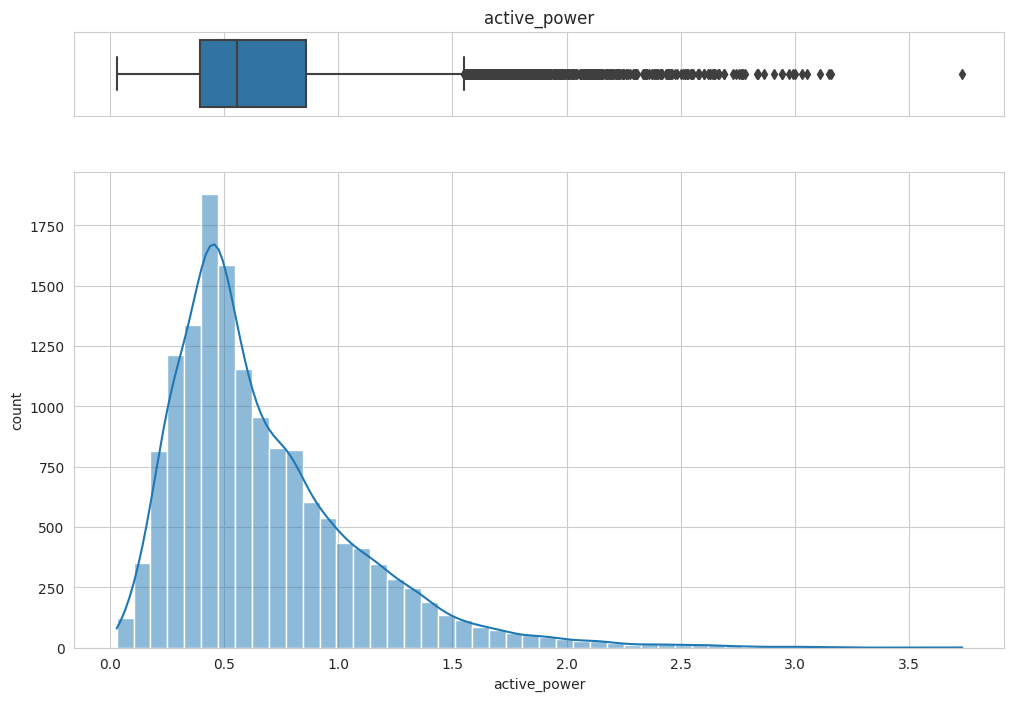

In [ ]:
gist_box(data_arc, 'active_power')

#### Реактивная мощность

Построим гистограмму и боксплот

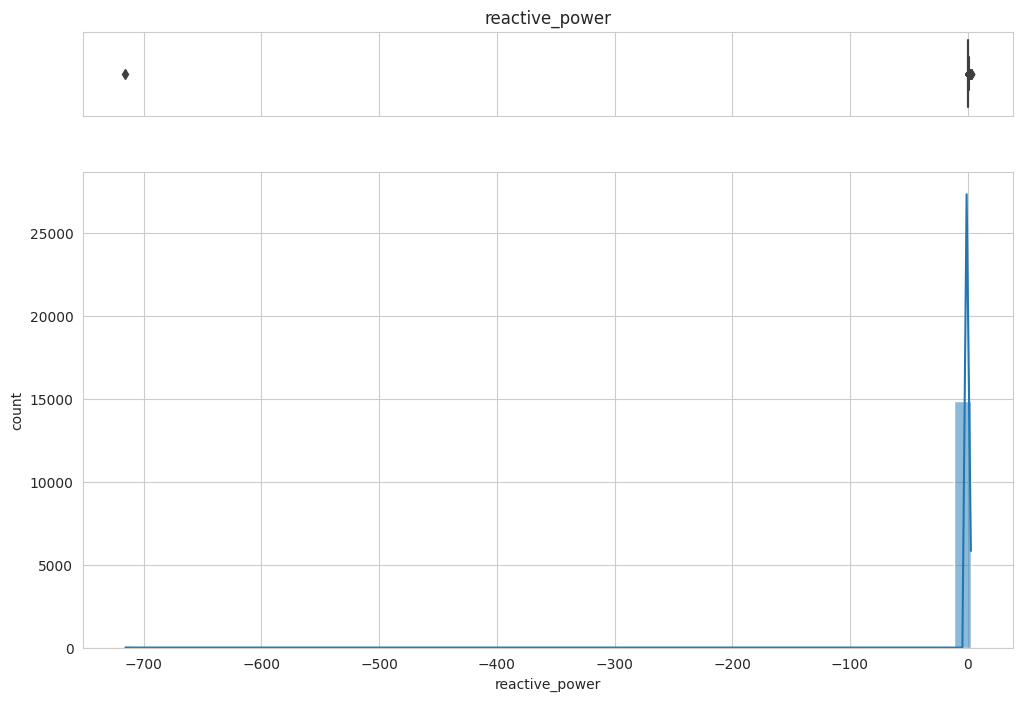

In [ ]:
gist_box(data_arc, 'reactive_power')

Видим сильный выброс со значением реактивной мощности -710. удалим его.

In [ ]:
data_arc.drop(data_arc[data_arc.reactive_power < 0].index,inplace=True)

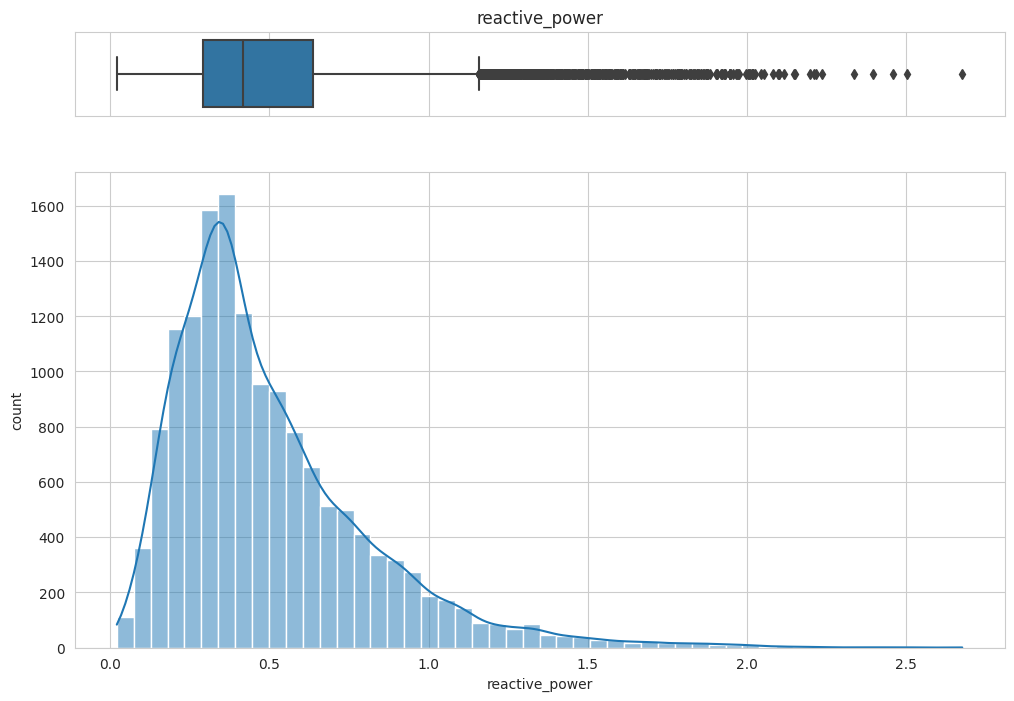

In [ ]:
gist_box(data_arc, 'reactive_power')

#### Полная мощность

Создадим новый признак - полная мощность
$$
S =  \sqrt(P^2 + Q^2)
$$

In [ ]:
data_arc.loc[:, 'apparent_power'] = np.sqrt(data_arc.active_power**2 + data_arc.reactive_power**2)

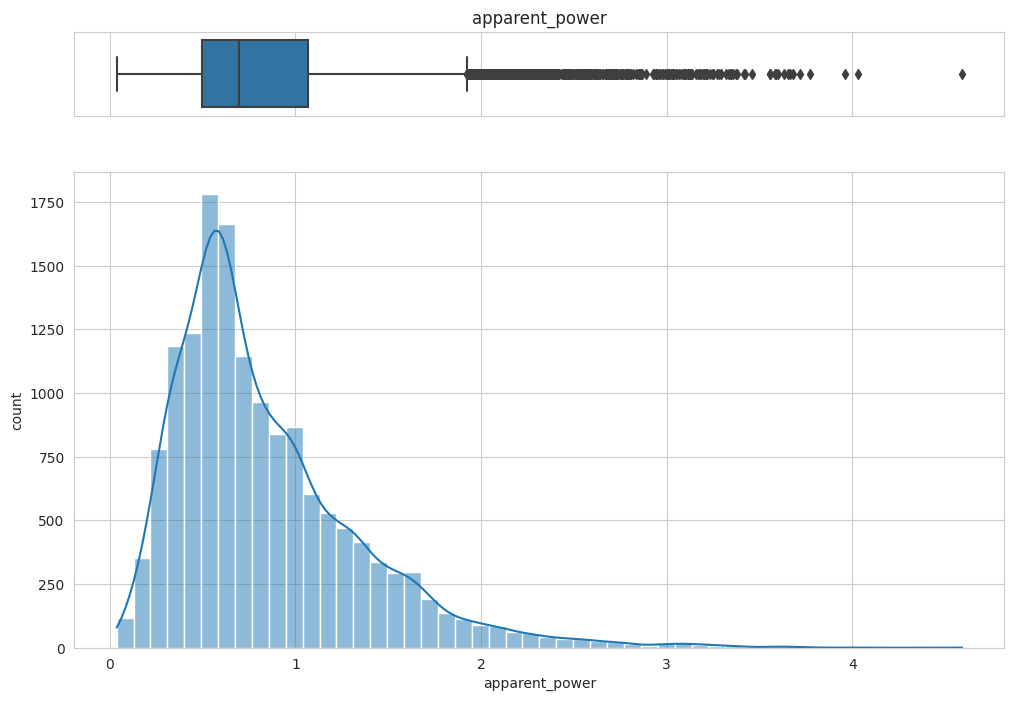

In [ ]:
gist_box(data_arc, 'apparent_power')

#### Коэффициент мощности

Созданим новый признак - коэффициент мощности

$$
cosφ= \frac{P}{S}
$$

P - активная мощность<br>
S - полнпя мощность

In [ ]:
data_arc.loc[:, 'cos_fi'] = data_arc.active_power / data_arc.apparent_power

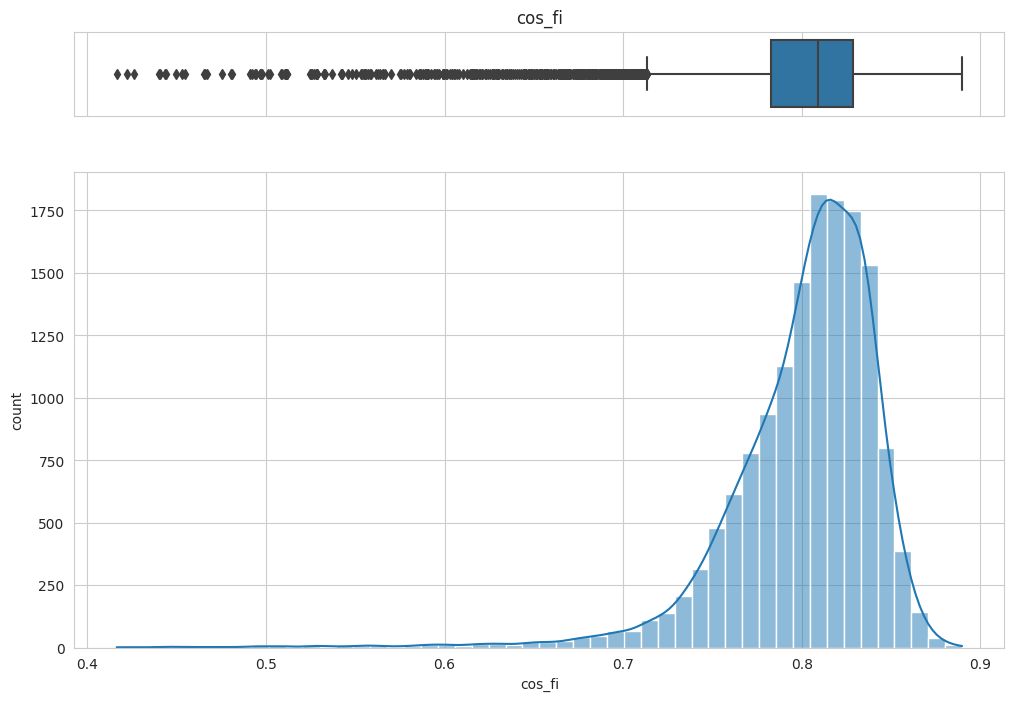

In [ ]:
gist_box(data_arc, 'cos_fi')

#### Количество запусков нагрева

In [ ]:
heat_sum = data_arc.key.value_counts(sort=False).reset_index(drop=True)

Отбросим признаки с временем начала и окончания нарева и оставим только длительность нагрева

In [ ]:
data_arc = data_arc[['key',
               'active_power',
               'reactive_power',
               'apparent_power',
               'cos_fi',
               'duration_heat'
               ]]

Идея перевести данные со значениями из одной партии из строк в столбцы. И оставить одну строку с одной партией, но значеними из этой партии в столцы

In [ ]:


agg_func = {
    'key'            : 'count',
    'active_power'   : 'mean',
    'reactive_power' : 'mean',
    'apparent_power' : 'sum',
    'cos_fi'         : 'mean',
    'duration_heat'  : 'mean'
}

data_arc = data_arc.groupby('key').agg(agg_func).rename(columns={'key':'heat_sum'}).reset_index()
data_arc

,key,heat_sum,active_power,reactive_power,apparent_power,cos_fi,duration_heat
0,1,5,0.975629,0.636648,5.826395,0.837756,219.60
1,2,4,0.763150,0.499528,3.649216,0.840158,202.75
2,3,5,0.505176,0.319815,2.989534,0.845421,131.00
3,4,4,0.802313,0.515074,3.814962,0.841682,185.25
4,5,4,0.836793,0.563161,4.035758,0.828104,217.25
...,...,...,...,...,...,...,...
3209,3237,5,0.786493,0.565692,4.844982,0.809908,181.80
3210,3238,3,0.702176,0.560394,2.696542,0.781519,182.00
3211,3239,8,0.583344,0.388952,5.611883,0.830510,152.00
3212,3240,5,0.596817,0.496653,3.891856,0.776241,167.80


Заполним пропуски 0

In [ ]:
data_arc = data_arc.fillna(0)

In [ ]:
data_arc.head()

,key,heat_sum,active_power,reactive_power,apparent_power,cos_fi,duration_heat
0,1,5,0.975629,0.636648,5.826395,0.837756,219.60
1,2,4,0.763150,0.499528,3.649216,0.840158,202.75
2,3,5,0.505176,0.319815,2.989534,0.845421,131.00
3,4,4,0.802313,0.515074,3.814962,0.841682,185.25
4,5,4,0.836793,0.563161,4.035758,0.828104,217.25


#### Вывод

В таблице `steel.data_arc`:
1. В данных нет пропусков и явных дубликатов.
2. Партии с аномальными значениями признаков были отброшены.
3. Сгенерированы новые признаки:
    1. Длительность нагрева
    1. Полная мощность
    2. Коэфициент мощности
    3. Количество запусков нагрева в партии

### Данные об объёме сыпучих материалов

  Таблица `data_bulk`

* `key` — номер партии
* `Bulk1 … Bulk15` — объём подаваемого материала

In [ ]:
fn_eda(data_bulk)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


''

'----------------------------------------------------'

'--------------Проверка на дубликаты-----------------'

'Количество дубликатов в датафрейме - 0'

''

'----------------------------------------------------'

'--------------Проверка на пропуски------------------'

'Таблица с признаками и пропускими в ник'

,% проаусков
bulk_8,99.968041
bulk_13,99.424736
bulk_9,99.392777
bulk_2,99.296900
bulk_7,99.201023
bulk_5,97.539150
bulk_10,94.375200
bulk_11,94.343241
bulk_1,91.946309
bulk_6,81.591563


''

'----------------------------------------------------'

'--------------Инфомация о датафрейме----------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


None

''

'----------------------------------------------------'

'--------------Описательные статистики---------------'

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
bulk_1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
bulk_2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
bulk_3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
bulk_4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
bulk_5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
bulk_6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
bulk_7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
bulk_8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
bulk_9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


''

''

'В датафрейме нет явных дубликатов'

Всего одно значение материала 8, также мало значений у материалов 2, 5, 7, 9 и 13

Построим диаграммы размаха для каждого материала.

In [ ]:
col = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']

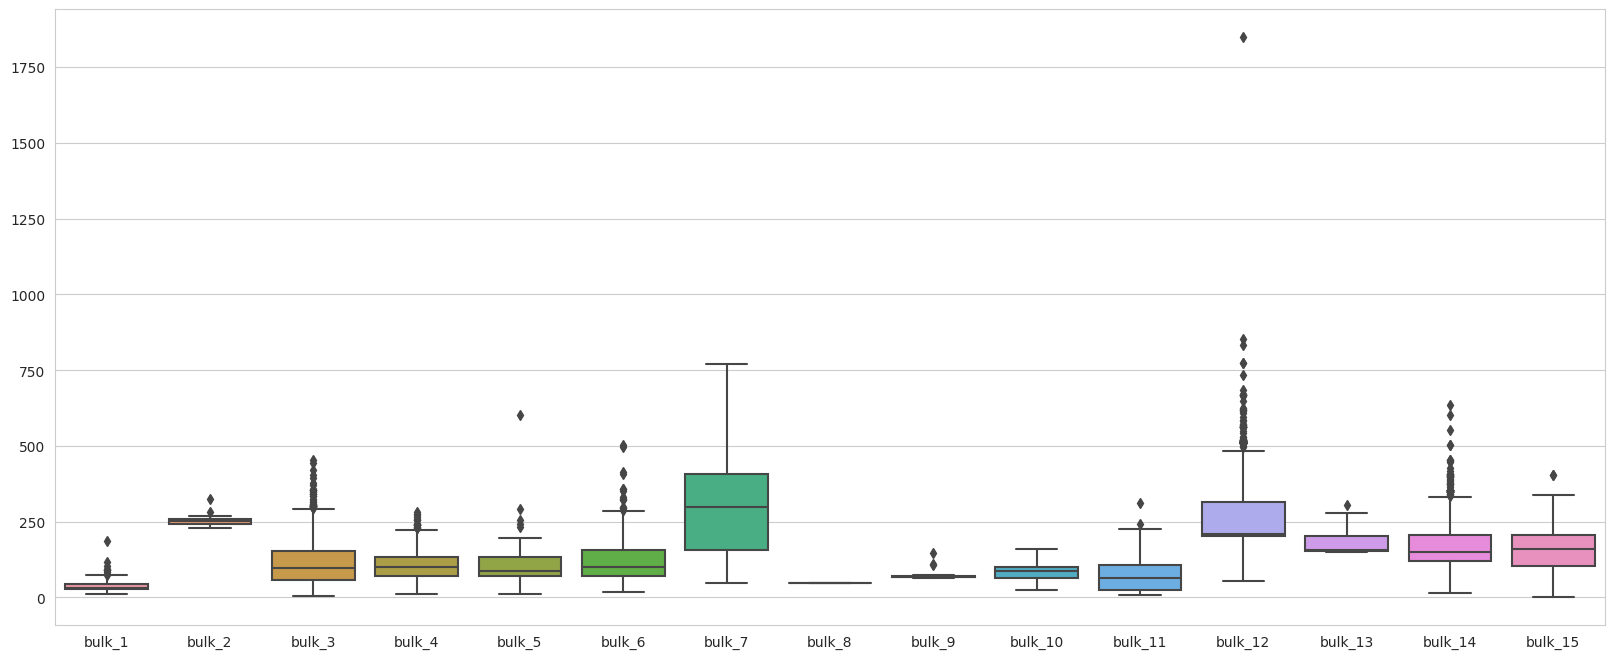

In [ ]:
plt.figure(figsize=(20,8))
sns.boxplot(data=data_bulk[col]);

Материал 12 содерит выброс, чтобы не потерять значения других материалов заменим анамальное значение на среднее значение для 12 материала.

In [ ]:
data_bulk.drop(data_bulk[data_bulk.bulk_12 > 1750].index,inplace=True)

Построим на распрежеление и диаграмму рассеивания каждого материала подробнее

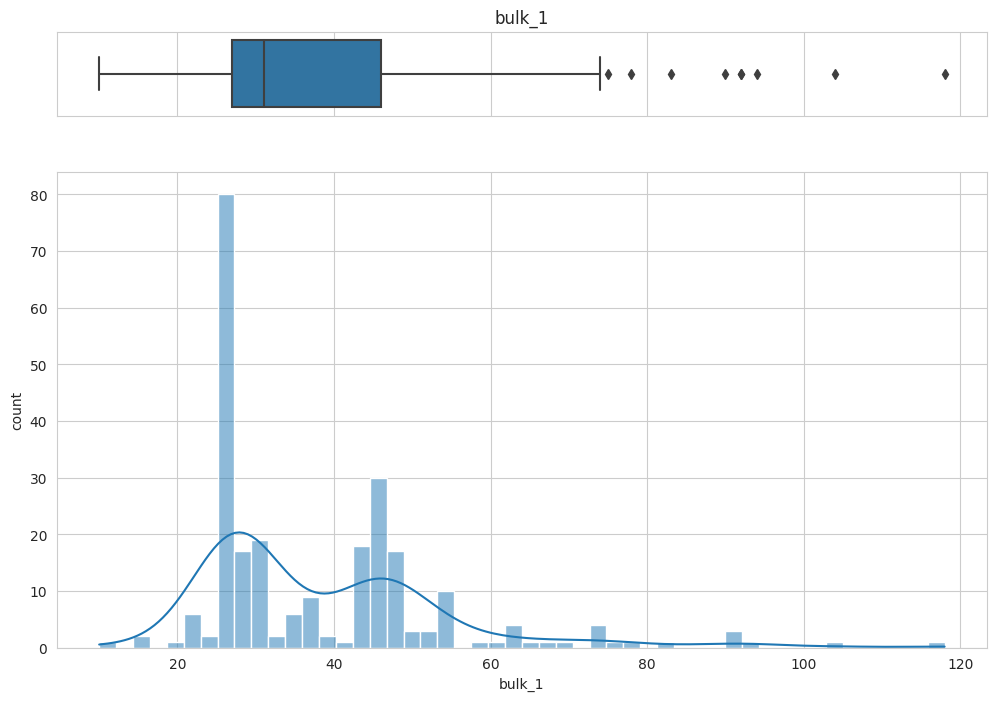

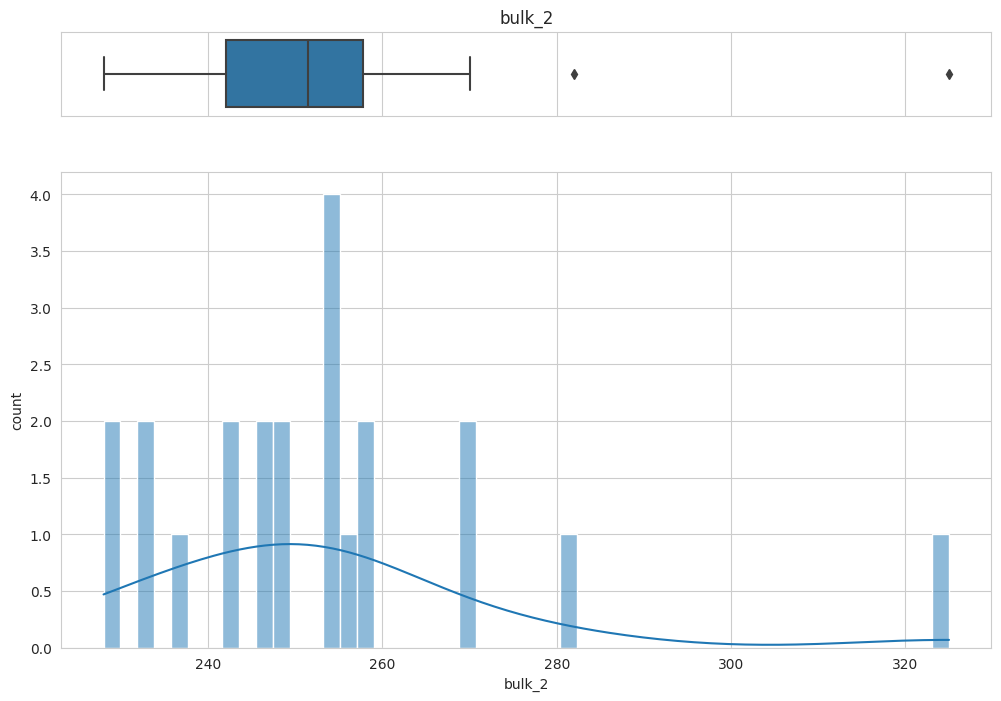

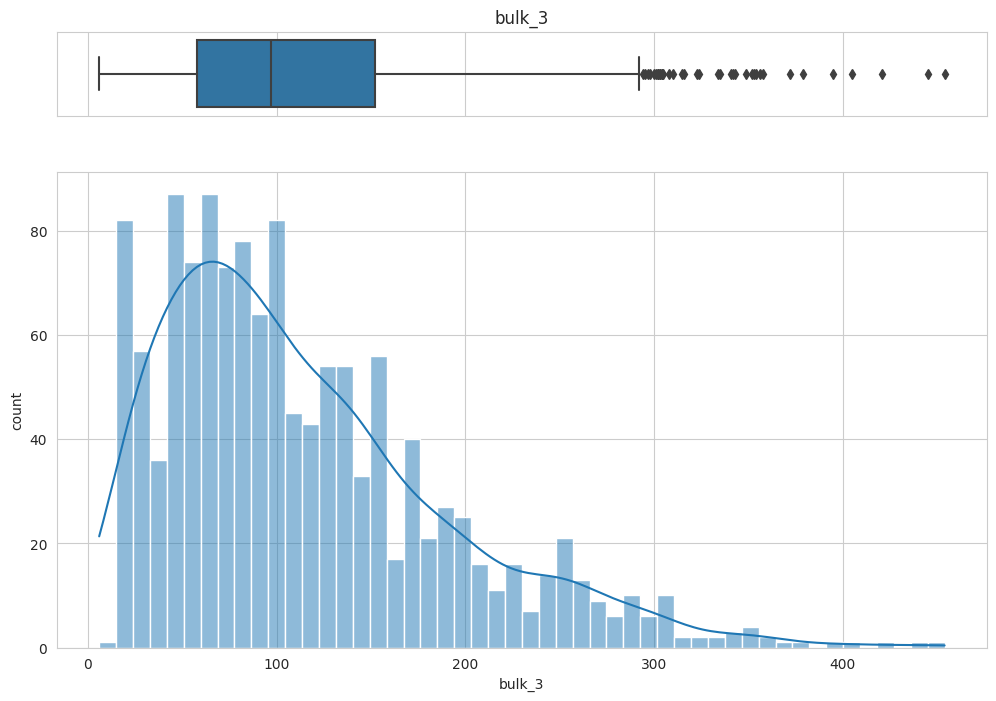

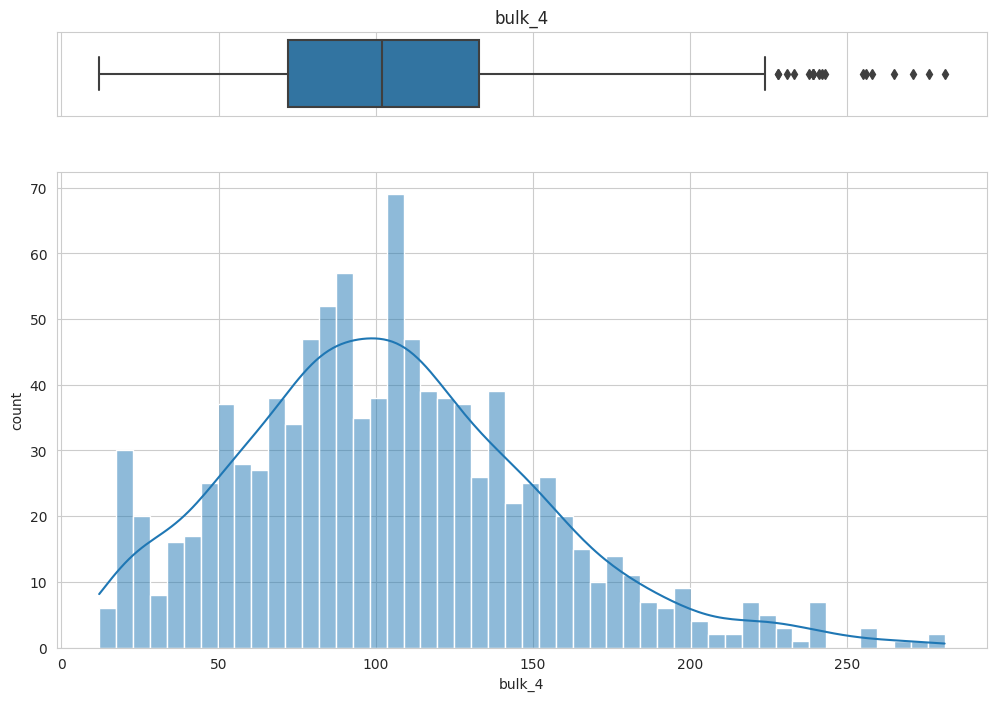

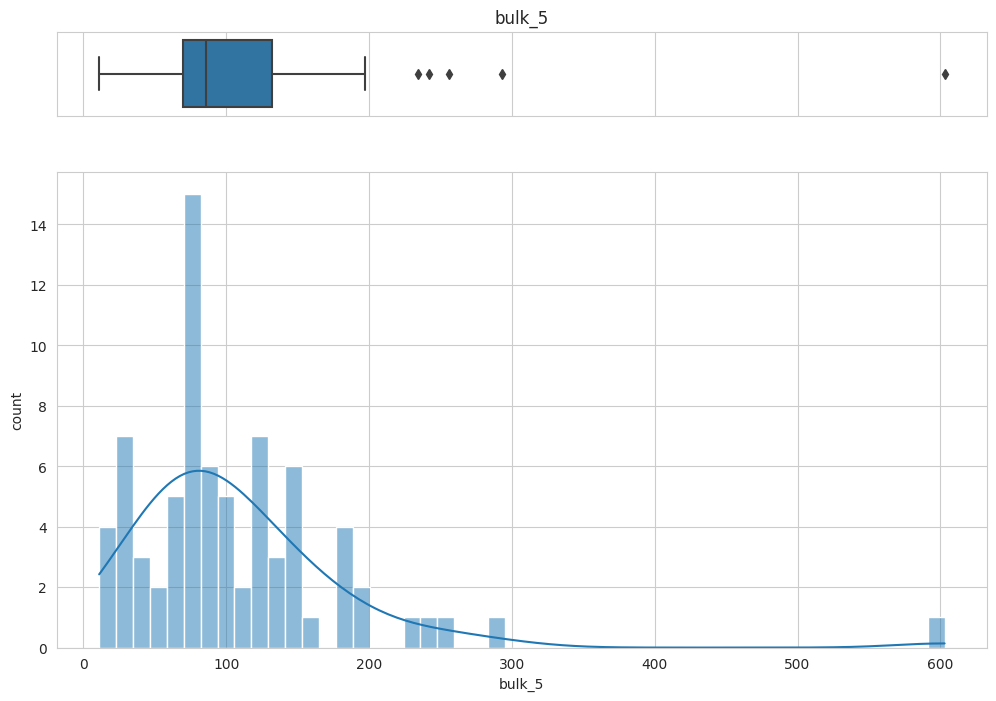

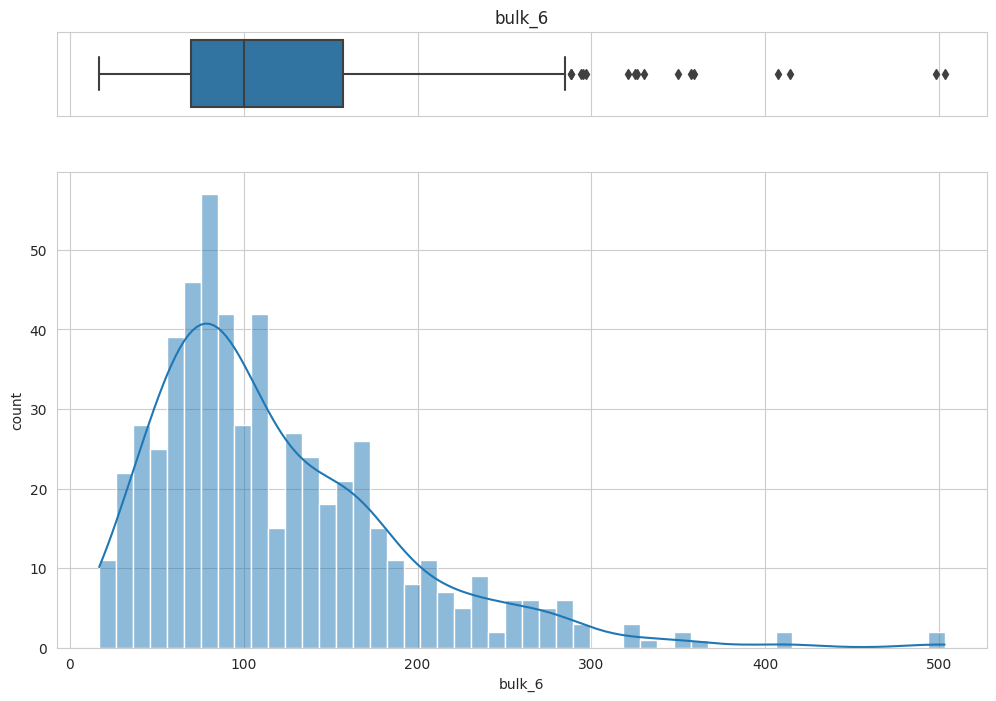

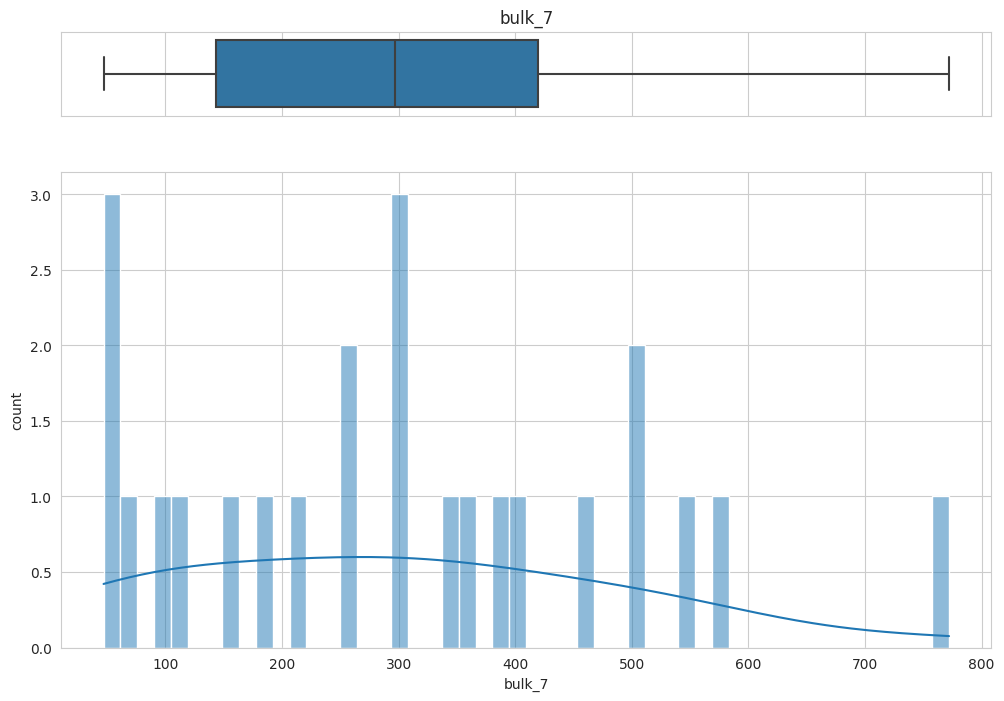

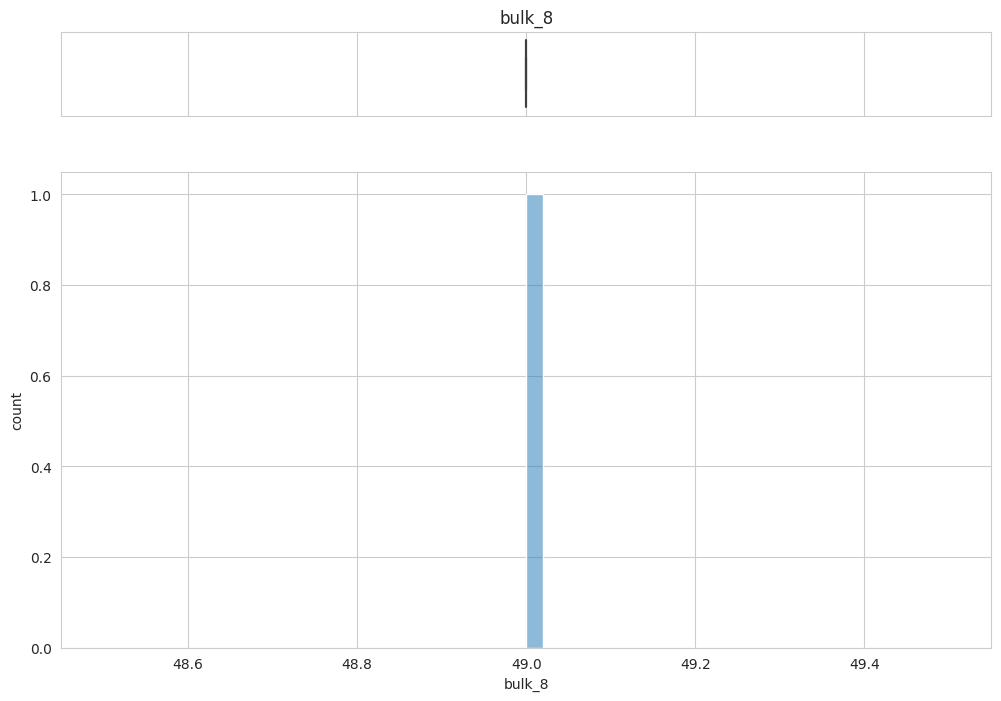

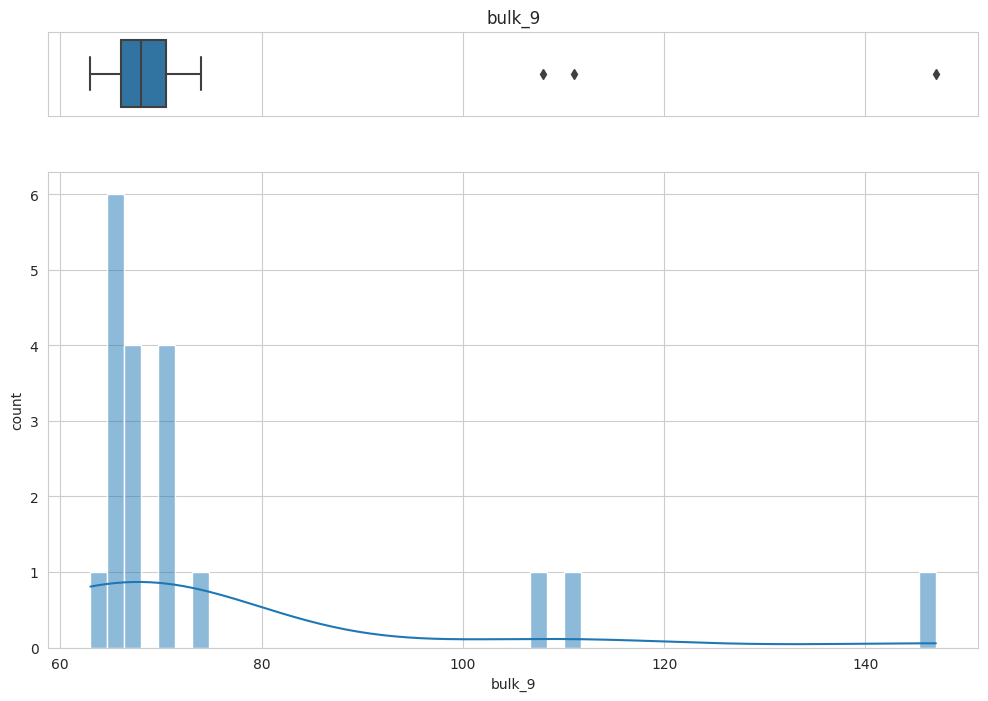

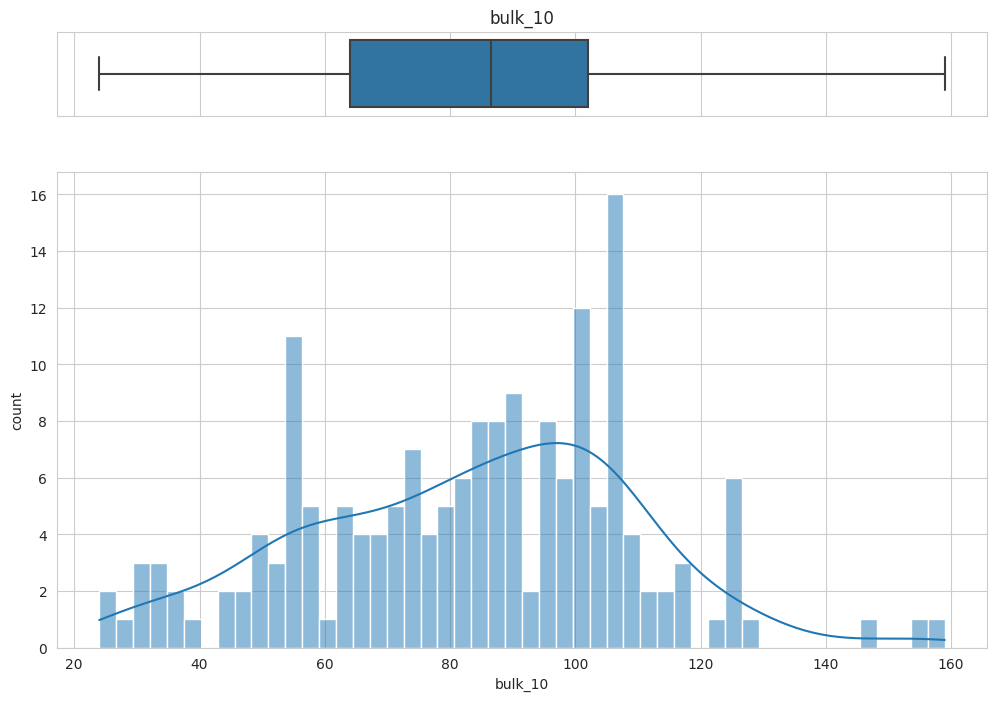

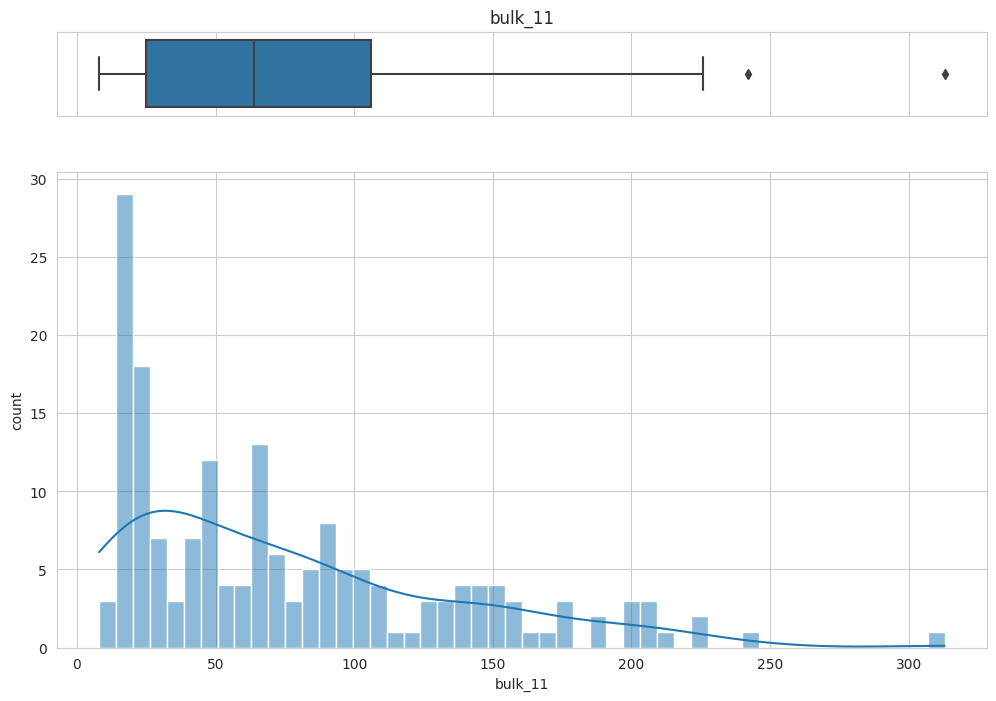

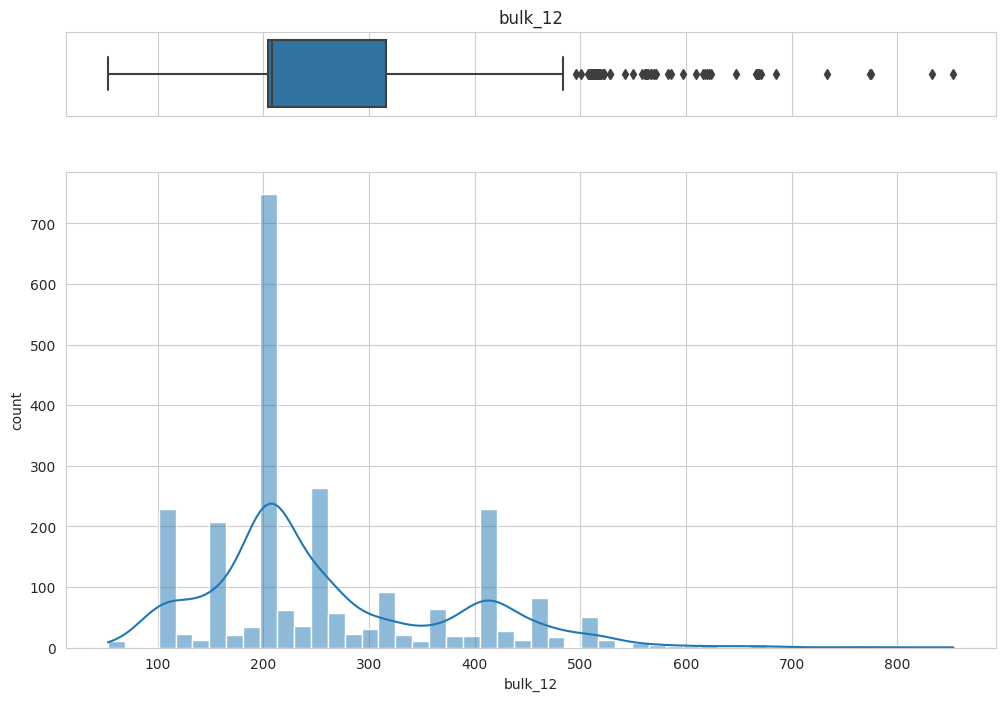

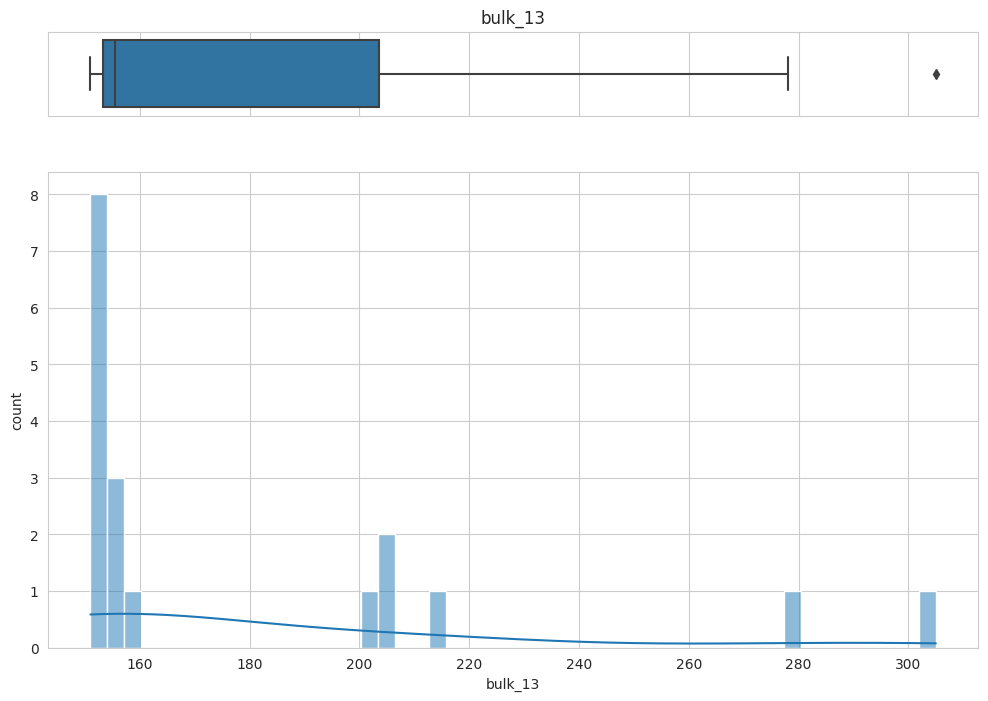

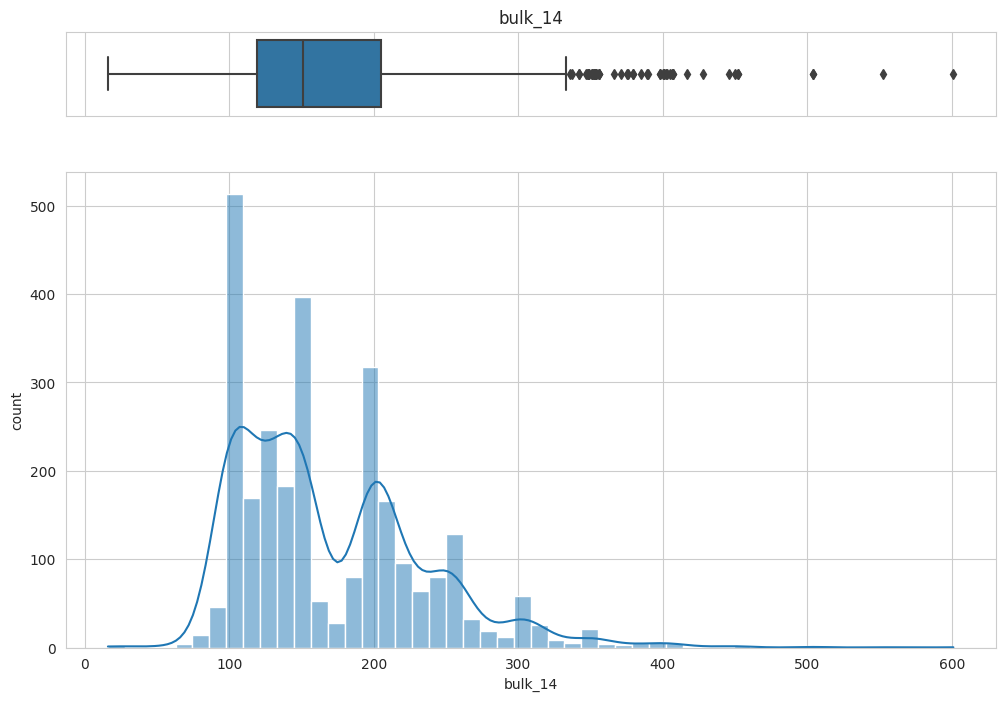

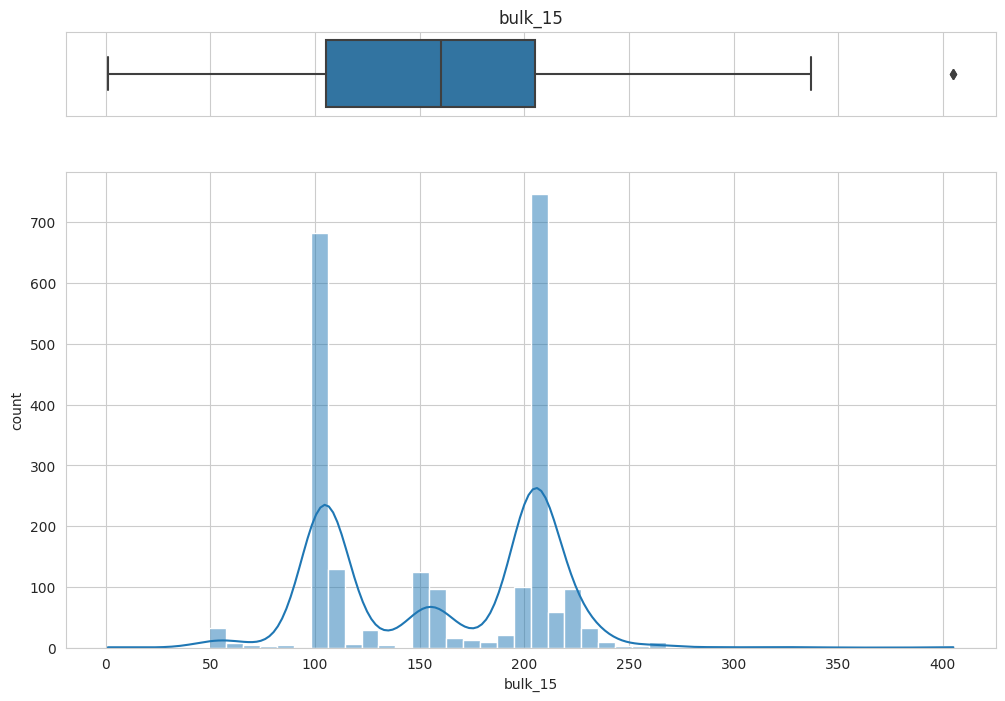

In [ ]:
for c in col:
 gist_box(data_bulk, c)

В данных есть пропуски. Из исходных данных известно, что если в данных пропуск, значит материал не добавлялся, заменим пропуски на 0

In [ ]:
data_bulk = data_bulk.fillna(0)

#### Количество добавок материала

In [ ]:
col = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']

In [ ]:
total = []
for index, row in data_bulk[col].iterrows():
  total.append((row > 0).sum())

In [ ]:
data_bulk['bulk_sum'] = total

In [ ]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,4
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,4
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,4
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,4
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,4


#### Вывод

1. Аномалии в данных заменены на медианные значения
2. Пропуски заполнены нулями
3. Создан новый признак количество добавок материала для каждой партии

In [ ]:
data_bulk.head()

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_sum
0,1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,4
1,2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,4
2,3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,4
3,4,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,4
4,5,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,4


### Данные о времени подачи сыпучих материалов

Таблица `data_bulk_time`

* `key` — номер партии
* `Bulk1 … Bulk15` — время подачи материала

In [ ]:
fn_eda(data_bulk_time)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,None,None,None,11:21:30,None,None,None,None,None,None,None,11:03:52,None,11:03:52,11:03:52
1,2,None,None,None,11:46:38,None,None,None,None,None,None,None,11:40:20,None,11:40:20,11:40:20
2,3,None,None,None,12:31:06,None,None,None,None,None,None,None,12:09:40,None,12:09:40,12:09:40
3,4,None,None,None,12:48:43,None,None,None,None,None,None,None,12:41:24,None,12:41:24,12:41:24
4,5,None,None,None,13:18:50,None,None,None,None,None,None,None,13:12:56,None,13:12:56,13:12:56


''

'----------------------------------------------------'

'--------------Проверка на дубликаты-----------------'

'Количество дубликатов в датафрейме - 0'

''

'----------------------------------------------------'

'--------------Проверка на пропуски------------------'

'Таблица с признаками и пропускими в ник'

,% проаусков
bulk_8,99.968041
bulk_13,99.424736
bulk_9,99.392777
bulk_2,99.296900
bulk_7,99.201023
bulk_5,97.539150
bulk_10,94.375200
bulk_11,94.343241
bulk_1,91.946309
bulk_6,81.591563


''

'----------------------------------------------------'

'--------------Инфомация о датафрейме----------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


None

''

'----------------------------------------------------'

'--------------Описательные статистики---------------'

,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0


''

''

'В датафрейме нет явных дубликатов'

В данных есть пропуски заполним их 0

In [ ]:
data_bulk_time = data_bulk_time.fillna(time(hour=0, minute=0, second=0))

In [ ]:
data_bulk_time

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,00:00:00,00:00:00,00:00:00,11:21:30,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,11:03:52,00:00:00,11:03:52,11:03:52
1,2,00:00:00,00:00:00,00:00:00,11:46:38,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,11:40:20,00:00:00,11:40:20,11:40:20
2,3,00:00:00,00:00:00,00:00:00,12:31:06,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,12:09:40,00:00:00,12:09:40,12:09:40
3,4,00:00:00,00:00:00,00:00:00,12:48:43,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,12:41:24,00:00:00,12:41:24,12:41:24
4,5,00:00:00,00:00:00,00:00:00,13:18:50,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,13:12:56,00:00:00,13:12:56,13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,00:00:00,00:00:00,22:51:28,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,22:46:52,00:00:00,22:46:52,22:46:52
3125,3238,00:00:00,00:00:00,23:39:11,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,23:33:09,00:00:00,23:33:09,23:33:09
3126,3239,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,01:51:58,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,01:39:41,00:00:00,01:33:25,01:33:25
3127,3240,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,03:12:40,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,02:41:27,02:41:27


Переведем в секунды с начала дня

In [ ]:
for i in range(1,16):
  data_bulk_time.loc[:, f'bulk_{i}'] = datetime_to_second(data_bulk_time[f'bulk_{i}'])

<ipython-input-68-f49d34f20820>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_bulk_time.loc[:, f'bulk_{i}'] = datetime_to_second(data_bulk_time[f'bulk_{i}'])


Добавим новый признак - продолжительность времени подачи материала

In [ ]:
col = ['bulk_1', 'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6',
       'bulk_7', 'bulk_8', 'bulk_9', 'bulk_10', 'bulk_11', 'bulk_12',
       'bulk_13', 'bulk_14', 'bulk_15']

In [ ]:
total = []
for index, row in data_bulk_time[col].iterrows():
  not_one = (row >= 0).mean()
  if not_one > 1/15:
    total.append(row.max() - row.loc[row > 1].min())
  else:
    total.append(0)

In [ ]:
data_bulk_time.loc[:, 'duration_bulk'] = pd.DataFrame(total)

Здесь тоже время начала и вреся окончания разные дни

In [ ]:
data_bulk_time.loc[data_bulk_time.duration_bulk > 16000, 'duration_bulk'] = 24*60*60 - data_bulk_time.duration_bulk

In [ ]:
data_bulk_time.duration_bulk.max() / 60 // 60

4.0

In [ ]:
data_bulk_time.duration_bulk.max() / 60 % 60

21.149999999999977

Максимальная продолжительность добавления компанентов 4 часа 21 минута. Не понятно адекватное это время или нет, следует уточнить у технологов. Посмотрим на распределение

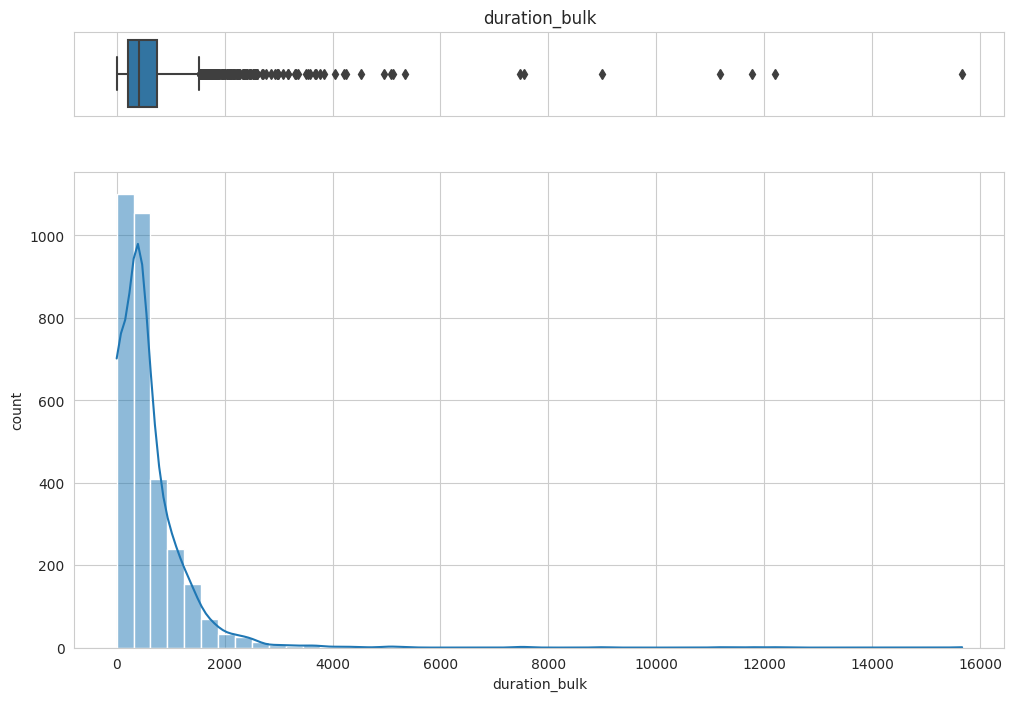

In [ ]:
gist_box(data_bulk_time, 'duration_bulk')

In [ ]:
data_bulk_time = data_bulk_time[['key', 'duration_bulk']]

#### Вывод

1. Аномалии в данных заменены на медианные значения
2. Пропуски заполнены нулями
3. Создан новый признак - длительность добавки материалов для каждой партии

In [ ]:
data_bulk_time.head()

,key,duration_bulk
0,1,1058
1,2,378
2,3,1286
3,4,439
4,5,354


### Данные о продувке сплава газом

Таблица `data_gas`

* `key` — номер партии
* `gas` — объём подаваемого газа

In [ ]:
fn_eda(data_gas)

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


''

'----------------------------------------------------'

'--------------Проверка на дубликаты-----------------'

'Количество дубликатов в датафрейме - 0'

''

'----------------------------------------------------'

'--------------Проверка на пропуски------------------'

'Таблица с признаками и пропускими в ник'

,% проаусков
key,0.0
gas,0.0


''

'----------------------------------------------------'

'--------------Инфомация о датафрейме----------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   gas     3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


None

''

'----------------------------------------------------'

'--------------Описательные статистики---------------'

,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
gas,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


''

''

'В датафрейме нет явных дубликатов'

Построим гистограмму и график распределения

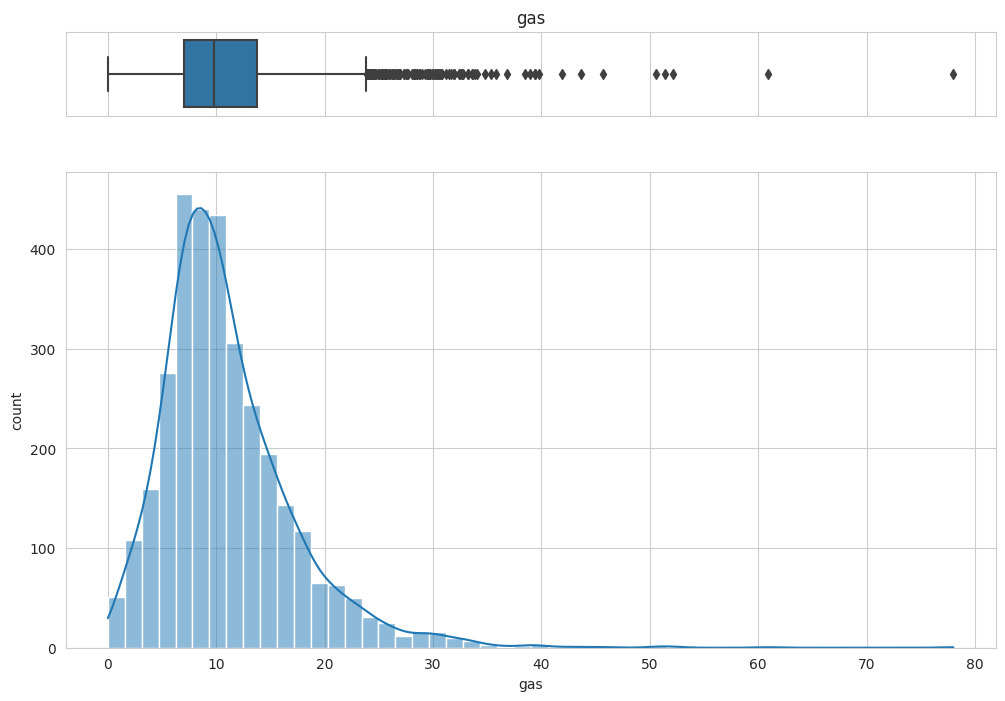

In [ ]:
gist_box(data_gas, 'gas')

Удалим данные со значением выше 60

In [ ]:
data_gas.drop(data_gas[data_gas.gas > 60].index,inplace=True)

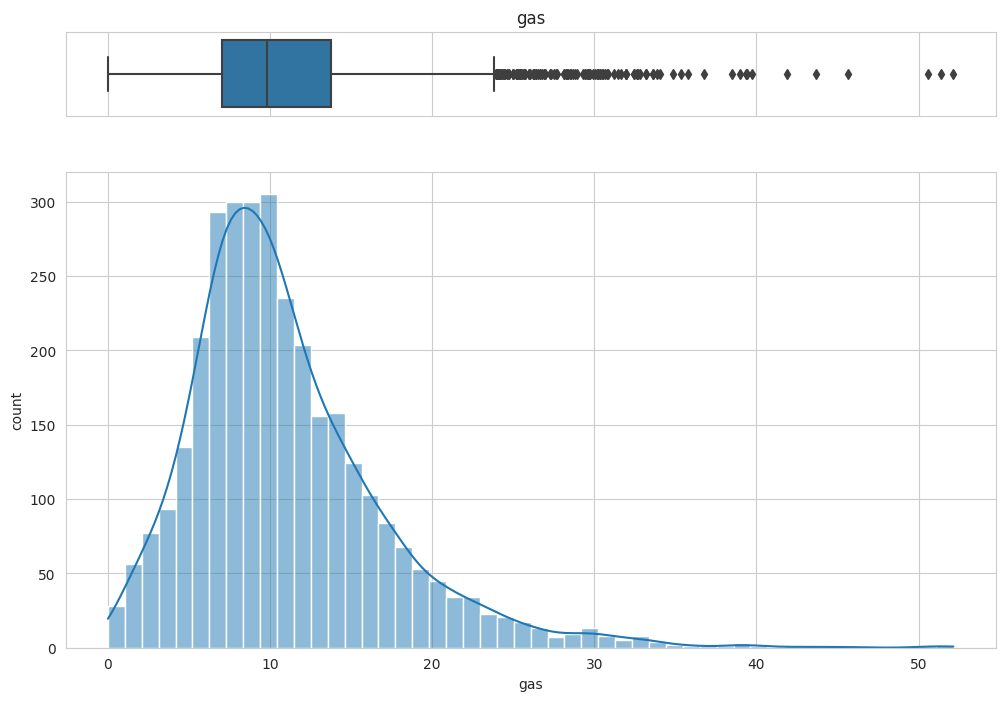

In [ ]:
gist_box(data_gas, 'gas')

#### Вывод

1. Аномалии в данных заменены на медианные значения
2. Пропусков в данных нет

In [ ]:
data_gas.head()

,key,gas
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


### Данные об измерениях температуры

Таблица `data_temp`

* `key` — номер партии
* `MesaureTime` — время замера
* `Temperature` — значение температуры

In [ ]:
fn_eda(data_temp)

,key,mesaure_time,temperature
0,1,11:16:18,1571.0
1,1,11:25:53,1604.0
2,1,11:29:11,1618.0
3,1,11:30:01,1601.0
4,1,11:30:39,1613.0


''

'----------------------------------------------------'

'--------------Проверка на дубликаты-----------------'

'Количество дубликатов в датафрейме - 0'

''

'----------------------------------------------------'

'--------------Проверка на пропуски------------------'

'Таблица с признаками и пропускими в ник'

,% проаусков
temperature,18.237254
key,0.000000
mesaure_time,0.000000


''

'----------------------------------------------------'

'--------------Инфомация о датафрейме----------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   mesaure_time  15907 non-null  object 
 2   temperature   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


None

''

'----------------------------------------------------'

'--------------Описательные статистики---------------'

,count,mean,std,min,25%,50%,75%,max
key,15907.0,1607.88087,942.212073,1.0,790.0,1618.0,2427.0,3241.0
temperature,13006.0,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0


''

''

'В датафрейме нет явных дубликатов'

Создадим новый признак - количество замеров температуры в партии

In [ ]:
temp_quantity = data_temp.key.value_counts(sort=False).reset_index(drop=True)

В значениях температуры есть пропуски. По условию заказчика целевой переменной является последнее измерение температуры. Проверим возможно есть пропуски между начальным и конечным замером

In [ ]:
# Создаем пустой датафрейм
res = pd.DataFrame()
temp_1= pd.DataFrame()
# Проходим циклом запускам
for i in range(1, int(data_temp.key[-1:])):
  # создание временного датафрейма
  # в который будут создаваться датафреймы
  # для одного разлива
  temp = data_temp.loc[data_temp.key == i]
  # сброс индексов
  temp = temp.reset_index()

  # добавление в новый датафрейм
  temp_1 = pd.concat([temp_1, temp[:1]])
  temp_1 = pd.concat([temp_1, temp[-1:]])
  temp_1 = temp_1.reset_index()

  # Проход циклом по признакам
  for colunm in ['mesaure_time', 'temperature']:

    # проход циклом по каждой записи которая соответствует признаку
    for k in range(1, len(temp_1)):
      #перевод признаков из гстроки в столбец
      temp_1.loc[:, colunm +f'_{k}'] = temp_1[colunm][k]

  #res = res.append(temp_1)
  res = pd.concat([res, temp_1])
  # сброс временного датафрейма
  temp = pd.DataFrame()
  temp_1 = pd.DataFrame()

res = res.drop(labels=[1], axis = 0)
# восстановление значения индексов датафрейма
# удаление коленки в которой хранились значения индексов
res = res.drop(['level_0', 'index'], axis=1)
res = res.reset_index(drop=True)

In [ ]:
res.head()

,key,mesaure_time,temperature,mesaure_time_1,temperature_1
0,1,11:16:18,1571.0,11:30:39,1613.0
1,2,11:37:27,1581.0,11:59:12,1602.0
2,3,12:13:17,1596.0,12:34:57,1599.0
3,4,12:52:57,1601.0,12:59:25,1625.0
4,5,13:23:19,1576.0,13:36:01,1602.0


Переименуем названия признаков

In [ ]:
res = res.rename(columns={'mesaure_time': 'mesaure_time_begin',
                          'temperature': 'temperature_begin',
                          'mesaure_time_1': 'mesaure_time_end',
                          'temperature_1': 'temperature_end'})

In [ ]:
data_temp = res.copy()

In [ ]:
data_temp#.sample(5)

,key,mesaure_time_begin,temperature_begin,mesaure_time_end,temperature_end
0,1,11:16:18,1571.0,11:30:39,1613.0
1,2,11:37:27,1581.0,11:59:12,1602.0
2,3,12:13:17,1596.0,12:34:57,1599.0
3,4,12:52:57,1601.0,12:59:25,1625.0
4,5,13:23:19,1576.0,13:36:01,1602.0
...,...,...,...,...,...
3210,3236,22:08:13,1607.0,22:31:42,NaN
3211,3237,22:44:04,1569.0,23:05:43,NaN
3212,3238,23:30:31,1584.0,23:43:00,NaN
3213,3239,01:31:47,1598.0,02:24:15,NaN


Количество замеров температуры

In [ ]:
data_temp['temp_quantity'] = temp_quantity

In [ ]:
data_temp.isna().mean()

key                   0.000000
mesaure_time_begin    0.000000
temperature_begin     0.000000
mesaure_time_end      0.000000
temperature_end       0.229549
temp_quantity         0.000000
dtype: float64

К сожадению отсутствуют именно послежние замеры температуры, которые являются нашей целевой переменной. Пропуски в 22 процентах данных.
<br> Отбросим эти значения

In [ ]:
data_temp = data_temp.dropna(axis=0)

 Также заказчик предупредил, что данные температуры ниже 1500 считаются аномальными. Отбросим эти значеия

In [ ]:
data_temp = data_temp.loc[~(data_temp['temperature_begin'] < 1500) | (data_temp['temperature_end'] < 1500)]

In [ ]:
data_temp = data_temp.reset_index()

In [ ]:
data_temp.isna().mean()

index                 0.0
key                   0.0
mesaure_time_begin    0.0
temperature_begin     0.0
mesaure_time_end      0.0
temperature_end       0.0
temp_quantity         0.0
dtype: float64

Переведем данные с временем замера температуры в секунды с начала дня

In [ ]:
data_temp['mesaure_time_begin'] = datetime_to_second(data_temp.mesaure_time_begin)

In [ ]:
data_temp['mesaure_time_end'] = datetime_to_second(data_temp.mesaure_time_end)

In [ ]:
data_temp = data_temp.drop('index', axis=1)

Проверим, есть ли такие партии, в которых температура окончания нагрева ниже, чем температура начала нагрева

In [ ]:
(data_temp.temperature_end - data_temp.temperature_begin <= 0).sum()

956

Таких ноблюдений 938. Отбросим их

In [ ]:
data_temp

,key,mesaure_time_begin,temperature_begin,mesaure_time_end,temperature_end,temp_quantity
0,1,40578,1571.0,41439,1613.0,5
1,2,41847,1581.0,43152,1602.0,6
2,3,43997,1596.0,45297,1599.0,5
3,4,46377,1601.0,46765,1625.0,3
4,5,48199,1576.0,48961,1602.0,2
...,...,...,...,...,...,...
2468,2495,2145,1570.0,3282,1591.0,3
2469,2496,3774,1554.0,5392,1591.0,4
2470,2497,6113,1571.0,6830,1589.0,2
2471,2498,7429,1591.0,8731,1594.0,5


#### Продолжительность нагрева

Создадим новый признак - продолжительность нагрева

In [ ]:
data_temp.loc[:, 'duration_temp'] = data_temp['mesaure_time_end'] - data_temp['mesaure_time_begin']

In [ ]:
data_temp = data_temp.drop(['mesaure_time_begin', 'mesaure_time_end'], axis=1)

Отбросим партии в которых менее 2 замеров

In [ ]:
data_temp = data_temp.loc[data_temp.temp_quantity > 2]

In [ ]:
(data_temp.temp_quantity < 2).sum()

0

#### Вывод

1. Аномалии в данных и пропуски в целевом признаке - отброшены.
3. Создан новый признак - продолжительность нагрева
3. Количество нагревов для каждой партии.

In [ ]:
data_temp.head()

,key,temperature_begin,temperature_end,temp_quantity,duration_temp
0,1,1571.0,1613.0,5,861
1,2,1581.0,1602.0,6,1305
2,3,1596.0,1599.0,5,1300
3,4,1601.0,1625.0,3,388
5,6,1543.0,1596.0,5,1385


### Данные об объёме проволочных материалов

Таблица `data_wire`

* `key` — номер партии
* `Wire1 … Wire15` — объём подаваемых проволочных материалов

In [ ]:
fn_eda(data_wire)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


''

'----------------------------------------------------'

'--------------Проверка на дубликаты-----------------'

'Количество дубликатов в датафрейме - 0'

''

'----------------------------------------------------'

'--------------Проверка на пропуски------------------'

'Таблица с признаками и пропускими в ник'

,% проаусков
wire_5,99.967543
wire_7,99.642973
wire_4,99.545602
wire_8,99.383317
wire_9,99.058747
wire_3,97.955209
wire_6,97.630639
wire_2,64.978903
wire_1,0.843882
key,0.000000


''

'----------------------------------------------------'

'--------------Инфомация о датафрейме----------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


None

''

'----------------------------------------------------'

'--------------Описательные статистики---------------'

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
wire_1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060484,330.314424
wire_2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
wire_3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
wire_4,14.0,57.442841,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
wire_5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
wire_6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
wire_7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
wire_8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
wire_9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


''

''

'В датафрейме нет явных дубликатов'

data_wire - не совпадает с описанием. всего 9, а в описании 15

In [ ]:
col = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']

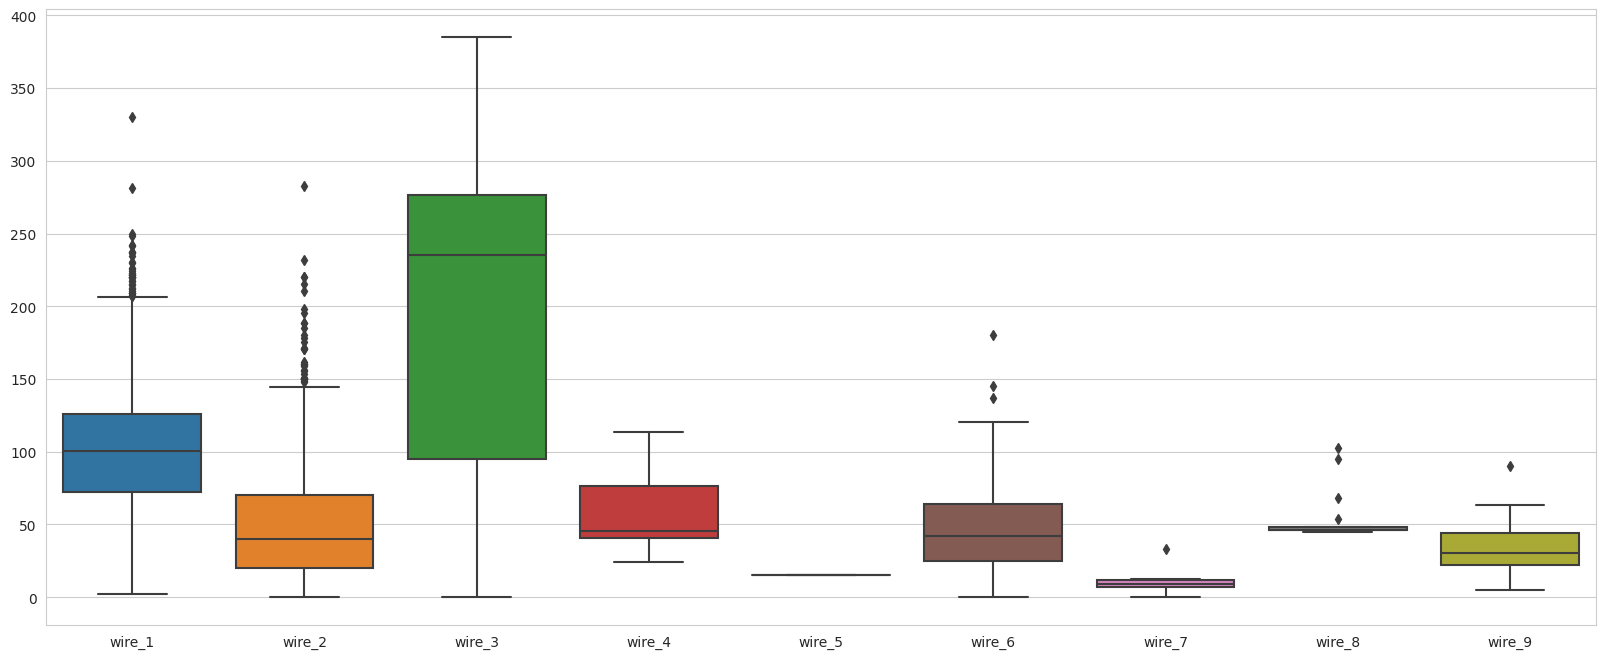

In [ ]:
plt.figure(figsize=(20,8))
sns.boxplot(data=data_wire[col]);

Заполним пропуски 0

In [ ]:
data_wire = data_wire.fillna(0)

#### Количество добавленных материалов

In [ ]:
col = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']

In [ ]:
total = []
for index, row in data_wire[col].iterrows():
  total.append((row > 0).sum())

In [ ]:
data_wire['wire_quantity'] = total

#### Вывод

1. Аномалии в данных заменены на медианные значения
2. Пропуски в данных заменени на 0
3. Создан новый признак - кодичество добавленных материалов для каждой партии

In [ ]:
data_wire.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_quantity
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


### Данные о времени подачи проволочных материалов

Таблица `data_wire_time`

* `key` — номер партии
* `Wire1 … Wire15` — время подачи проволочных материалов

In [ ]:
fn_eda(data_wire_time)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,11:11:41,None,None,None,None,None,None,None,None
1,2,11:46:10,None,None,None,None,None,None,None,None
2,3,12:13:47,None,None,None,None,None,None,None,None
3,4,12:48:05,None,None,None,None,None,None,None,None
4,5,13:18:15,13:32:06,None,None,None,None,None,None,None


''

'----------------------------------------------------'

'--------------Проверка на дубликаты-----------------'

'Количество дубликатов в датафрейме - 0'

''

'----------------------------------------------------'

'--------------Проверка на пропуски------------------'

'Таблица с признаками и пропускими в ник'

,% проаусков
wire_5,99.967543
wire_7,99.642973
wire_4,99.545602
wire_8,99.383317
wire_9,99.058747
wire_3,97.955209
wire_6,97.630639
wire_2,64.978903
wire_1,0.843882
key,0.000000


''

'----------------------------------------------------'

'--------------Инфомация о датафрейме----------------'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


None

''

'----------------------------------------------------'

'--------------Описательные статистики---------------'

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0


''

''

'В датафрейме нет явных дубликатов'

Заполним пропуски 0

In [ ]:
data_wire_time = data_wire_time.fillna(time(hour=0, minute=0, second=0))

In [ ]:
data_wire_time.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,11:11:41,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
1,2,11:46:10,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
2,3,12:13:47,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
3,4,12:48:05,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00
4,5,13:18:15,13:32:06,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00,00:00:00


In [ ]:
col = ['wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_5', 'wire_6',
       'wire_7', 'wire_8', 'wire_9']

In [ ]:
for i in col:
  data_wire_time.loc[:, f'{i}'] = datetime_to_second(data_wire_time[f'{i}'])

<ipython-input-123-ee9140de64c1>:2: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  data_wire_time.loc[:, f'{i}'] = datetime_to_second(data_wire_time[f'{i}'])


In [ ]:
data_wire_time

NameError: ignored

In [ ]:
total = []
for index, row in data_wire_time[col].iterrows():
  not_one = (row >= 0).mean()
  if not_one > 1/9:
    total.append(row.max() - row.loc[row > 1].min())
  else:
    total.append(0)

In [ ]:
data_wire_time.loc[:, 'duration_wire'] = pd.DataFrame(total)

In [ ]:
data_wire_time.loc[data_wire_time.duration_wire > 20000, 'duration_wire'] = 24*60*60 - data_wire_time.duration_wire

In [ ]:
data_wire_time.duration_wire.max() / 60 // 60

5.0

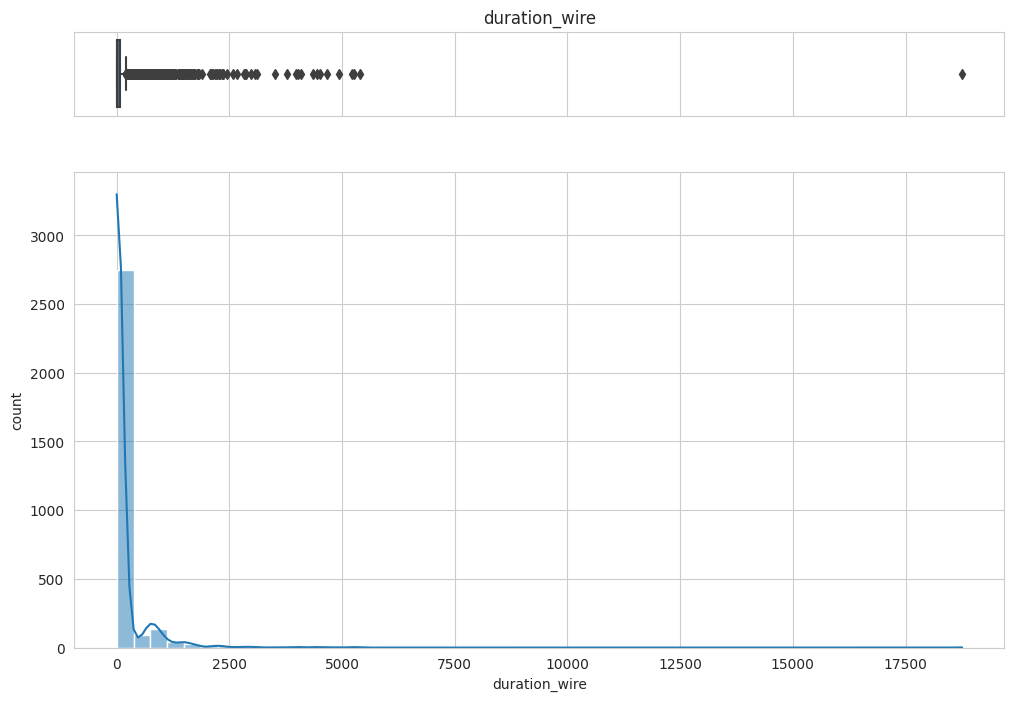

In [ ]:
gist_box(data_wire_time, 'duration_wire')

In [ ]:
data_wire_time = data_wire_time[['key','duration_wire']]

In [ ]:
data_wire_time.describe().T

,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0
duration_wire,3081.0,158.987666,563.367647,0.0,0.0,0.0,80.0,18756.0


#### Вывод

1. Аномалии в данных заменены на медианные значения
2. Пропуски в данных заменени на 0
3. Создан новый признак - длительность подачи материалов для каждой партии

In [ ]:
data_wire_time.head()

,key,duration_wire
0,1,0
1,2,0
2,3,0
3,4,0
4,5,831


### Объединение таблиц

In [ ]:
data_arc.shape[1] + data_bulk.shape[1] + data_bulk_time.shape[1] + \
data_gas.shape[1] + data_temp.shape[1] + data_wire.shape[1] + data_wire_time.shape[1] - 6

40

In [ ]:
df= pd.DataFrame()

In [ ]:
df = data_temp.merge(data_arc, how='inner', on='key')

In [ ]:
df = df.merge(data_bulk, how='inner', on='key')

In [ ]:
df = df.merge(data_bulk_time, how='inner', on='key')

In [ ]:
df = df.merge(data_gas, how='inner', on='key')

In [ ]:
df = df.merge(data_wire, how='inner', on='key')

In [ ]:
df = df.merge(data_wire_time, how='inner', on='key')

In [ ]:
data_temp.shape[0] - df.shape[0]

139

In [ ]:
df

,key,temperature_begin,temperature_end,temp_quantity,duration_temp,heat_sum,active_power,reactive_power,apparent_power,cos_fi,...,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,wire_quantity,duration_wire
0,1,1571.0,1613.0,5,861,5,0.975629,0.636648,5.826395,0.837756,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
1,2,1581.0,1602.0,6,1305,4,0.763150,0.499528,3.649216,0.840158,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2,3,1596.0,1599.0,5,1300,5,0.505176,0.319815,2.989534,0.845421,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
3,4,1601.0,1625.0,3,388,4,0.802313,0.515074,3.814962,0.841682,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,6,1543.0,1596.0,5,1385,4,0.988777,0.672294,4.786837,0.830749,...,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2271,2494,1585.0,1591.0,3,626,3,0.833013,0.585333,3.054613,0.820819,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2272,2495,1570.0,1591.0,3,1137,4,0.802673,0.590194,3.986869,0.807313,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2273,2496,1554.0,1591.0,4,1618,6,0.700511,0.468364,5.057033,0.829826,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
2274,2498,1591.0,1594.0,5,1302,5,0.681745,0.471086,4.143749,0.826522,...,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


### Проверка признаков на мультиколлинеарность

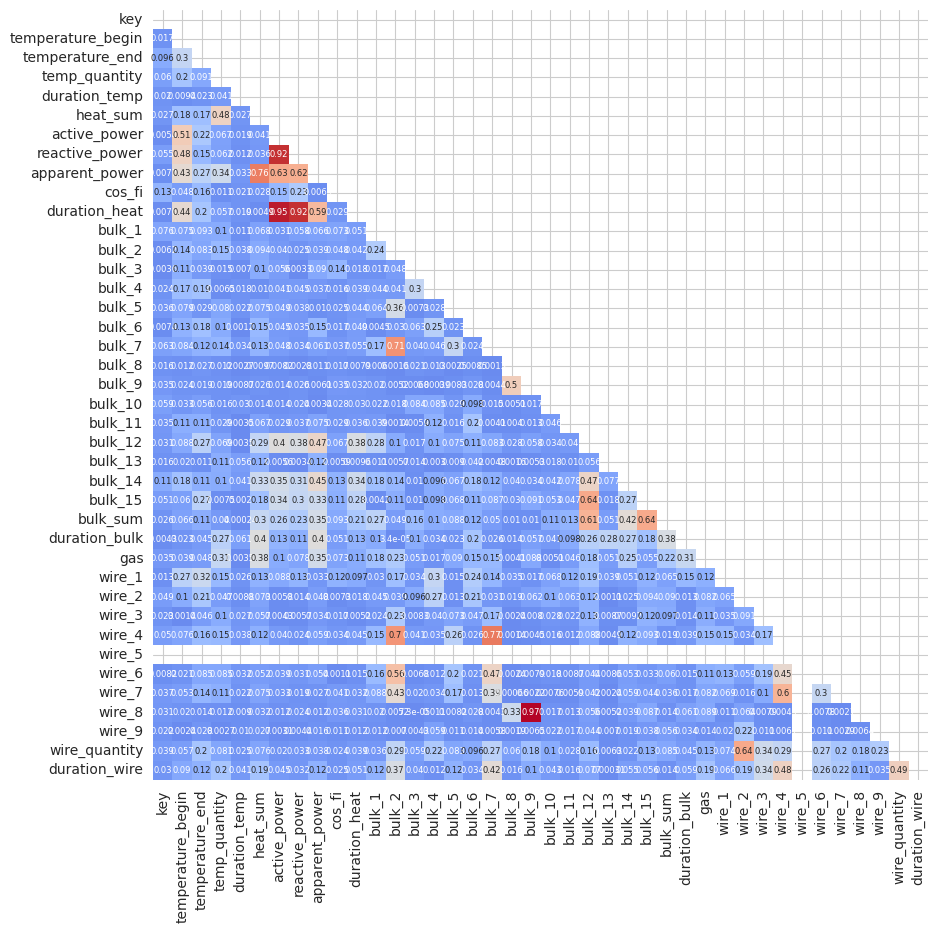

In [ ]:
fig = plt.figure(figsize=(10, 10))

sns.heatmap( df.corr().abs(),
             cmap="coolwarm", fmt='.2g',
             cbar=False,
             center=0.4,
             annot=True,
             annot_kws={'fontsize': 6},
             mask=np.triu(df.corr()))

plt.show()

Признак `duration_heat` коррелирует с признаками `active_power` и `reactive_power` -- удалим `duration_heat`
Признаки `active_power` и `reactive_power`имеют мультиколинеарнось -- удалим признак `reactive_power` <br>
Признаки `bulk_9` и `wire_8` имеют мультиколинеарнось -- удалим признак `bulk_9`

In [ ]:
df = df.drop(['bulk_9',  'reactive_power', 'active_power'], axis=1)

#### Вывод

Таблицы с данными объеденены в одну общу. Каждой партии сответствует одно наблюдение.<br>
Сильно коррелирующие признаки были удалены.

### Вывод:


1. Исходные данные проанализированны, все таблицы содержат данные
 и количество таблиц совпадает с условием задачи.
2. В таблице `steel.data_arc`:
    1. В данных нет пропусков и явных дубликатов.
    2. Партии с аномальными значениями признаков были заменены заменены на медианные значения.
    3. Сгенерированы новые признаки:
        1. Длительность нагрева
        1. Полная мощность
        2. Коэфициент мощности
        3. Количество запусков нагрева в партии
    4. Данные собраны по номеру партии, так, чтобы в наборе данных осталась одна запись соответствующая номеру партии, а значения наблюдений из этой партии переведены в признаки.

3. Для таблицы `steel.data_bulk`:
    1. Аномалии в данных заменены на медианные значения
    2. Пропуски заполнены нулями
    3. Создан новый признак - количество добавок материала для каждой партии

4. Для таблицы `steel.data_bulk_time`:
    1. Аномалии в данных заменены на медианные значения
    2. Пропуски заполнены нулями
    3. Создан новый признак - длительность добавки материалов для каждой партии

5. Для таблицы `steel.data_gas`:
    1. Аномалии в данных заменены на медианные значения
    2. Пропусков в данных нет

6. Для таблицы `steel.data_temp`:
    1. Аномалии в данных и пропуски в целевом признаке - отброшены.
    2. Создан новый признак - продолжительность нагрева
    3. Количество нагревов для каждой партии.

7. Для таблицы `steel.data_wire`:
    1. Аномалии в данных заменены на медианные значения
    2. Пропуски в данных заменени на 0
    3. Создан новый признак - кодичество добавленных материалов для каждой партии

8. Для таблицы `steel.data_wire_time`:

    1. Аномалии в данных заменены на медианные значения
    2. Пропуски в данных заменени на 0
    3. Создан новый признак - длительность подачи материалов для каждой партии

9. Объедините таблицы по ключу:

    1. Таблицы с данными объеденены в одну общу.
    2. Каждой портии сответствует одно наблюдение.
    

## Обучение моделей

### Разбиение на обучающую, валидационную и тестовую выборки

In [ ]:
drop_features = ['temperature_end']

In [ ]:
X = df.drop(drop_features, axis=1)
y = df.temperature_end

In [ ]:
X_train_v, X_test, y_train_v, y_test = train_test_split(X, y,
                                                        random_state=RANDOM_STATE,
                                                        test_size=.25)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_v, y_train_v,
                                                  random_state=RANDOM_STATE,
                                                  test_size=.2)

Проверка корректности разбиения

In [ ]:
X_train.shape[0] + X_val.shape[0] + X_test.shape[0] == df.shape[0]

True

In [ ]:
y_train.shape[0]+ y_val.shape[0] + y_test.shape[0] == df.shape[0]

True

### Константная модель

In [ ]:
dummy = DummyRegressor()

dummy.fit(X_train, y_train)

predict = dummy.predict(X_val)

mae_dummy  = mean_absolute_error(y_val,predict)

print('MAE на валидации',mae_dummy)

MAE на валидации 7.100269905533075


### RandomForestRegressor

Подберем значения гиперпараметров с помощью RandomizedSearchCV

In [ ]:
n_estimators = [5,20,50,100]
max_depth = [int(x) for x in np.linspace(10, 120, num = 12)]
min_samples_split = [2, 6, 10]
min_samples_leaf = [1, 3, 4]

random_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf
    }

In [ ]:
rfr = RandomForestRegressor(random_state=RANDOM_STATE,
                            criterion='absolute_error')

In [ ]:
rfr_random = RandomizedSearchCV(estimator=rfr,
                                param_distributions=random_grid,
                                n_iter=100,
                                cv=2,
                                verbose=2,
                                random_state=RANDOM_STATE,scoring='neg_mean_absolute_error',
                                n_jobs = -1)

In [ ]:
rfr_random.fit(X_train_v, y_train_v)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


RandomizedSearchCV(cv=2,
                   estimator=RandomForestRegressor(criterion='absolute_error',
                                                   random_state=161023),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      120],
                                        'min_samples_leaf': [1, 3, 4],
                                        'min_samples_split': [2, 6, 10],
                                        'n_estimators': [5, 20, 50, 100]},
                   random_state=161023, scoring='neg_mean_absolute_error',
                   verbose=2)

Вывод на экран лучших параметров

In [ ]:
rfr_random.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_depth': 100}

In [ ]:
mae_rfr = rfr_random.best_score_ * -1
mae_rfr

6.127703658529889

### CatBoostRegressor

Подберем значения гиперпараметров с помощью Optuna

In [ ]:
def objective(trial):

    param = {}

    param['learning_rate'] = trial.suggest_float("learning_rate", 0.01, 0.03, step = 0.01)
    param['depth'] = trial.suggest_int('depth', 5, 8)
    param['l2_leaf_reg'] = trial.suggest_float('l2_leaf_reg', 1.0, 5.0, step = 0.5)
    param['min_child_samples'] = trial.suggest_categorical('min_child_samples', [1, 4, 8, 16, 32])

    cbr = CatBoostRegressor(**param,
                            silent=True,
                            random_state=RANDOM_STATE,
                            iterations=1000,
                            grow_policy='Depthwise',
                            eval_metric='MAE'
                            )

    cbr.fit(X_train, y_train)
    y_pred_cbr = cbr.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred_cbr)

    return mae

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30)

[I 2023-10-24 23:06:21,158] A new study created in memory with name: no-name-7810cd54-9892-487b-a5a6-e5d459cae728
[I 2023-10-24 23:06:25,501] Trial 0 finished with value: 4.893850994236759 and parameters: {'learning_rate': 0.02, 'depth': 6, 'l2_leaf_reg': 4.0, 'min_child_samples': 16}. Best is trial 0 with value: 4.893850994236759.
[I 2023-10-24 23:06:30,062] Trial 1 finished with value: 4.9267128363893695 and parameters: {'learning_rate': 0.01, 'depth': 6, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 0 with value: 4.893850994236759.
[I 2023-10-24 23:06:36,459] Trial 2 finished with value: 4.904722900483351 and parameters: {'learning_rate': 0.03, 'depth': 7, 'l2_leaf_reg': 1.0, 'min_child_samples': 16}. Best is trial 0 with value: 4.893850994236759.
[I 2023-10-24 23:06:40,173] Trial 3 finished with value: 4.894982499121071 and parameters: {'learning_rate': 0.01, 'depth': 6, 'l2_leaf_reg': 2.5, 'min_child_samples': 32}. Best is trial 0 with value: 4.893850994236759.
[I 20

In [ ]:
print('Best hyperparameters:', study.best_params)
print('Best MAE:', study.best_value)

Best hyperparameters: {'learning_rate': 0.02, 'depth': 5, 'l2_leaf_reg': 2.5, 'min_child_samples': 1}
Best MAE: 4.863823071479565


In [ ]:
mae_cbr = study.best_value

### Нейросеть

In [ ]:
# Перевод выборок в тензоры
X_train_nn = torch.FloatTensor(np.array(X_train))
X_val_nn = torch.FloatTensor(np.array(X_val))
X_test_nn = torch.FloatTensor(np.array(X_test))


y_train_nn = torch.FloatTensor(np.array(y_train))
y_val_nn = torch.FloatTensor(np.array(y_val))
y_test_nn = torch.FloatTensor(np.array(y_test))

In [ ]:
# Задание количества нейронов в слоях
n_in_neurons = X_train_nn.shape[1]
n_hidden_neurons_1 = 50
n_hidden_neurons_2 = 25
n_out_neurons = 1

# Создание нейронной сети
net = Net(n_in_neurons,
          n_hidden_neurons_1,
          n_hidden_neurons_2,
          n_out_neurons,
          drop_out=0)

# Оптимизатор
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

loss = nn.L1Loss()

In [ ]:
dataset_train = torch.utils.data.TensorDataset(X_train_nn, y_train_nn)
dataset_val = torch.utils.data.TensorDataset(X_val_nn, y_val_nn)

train_dataloader = DataLoader(dataset_train,
                              batch_size=40,
                              shuffle=True,
                              num_workers=0)

val_dataloader = DataLoader(dataset_val,
                            batch_size=40,
                            num_workers=0)

In [ ]:
_,_, predicted_temp = fit_net(net)

epoch:0, MAE test: 1590.1536865234375
epoch:200, MAE test: 7.919986248016357
INFO: Early stopping counter 1 of 5
epoch:400, MAE test: 7.700339317321777
INFO: Early stopping counter 2 of 5
epoch:600, MAE test: 7.61467170715332
INFO: Early stopping counter 3 of 5
epoch:800, MAE test: 7.717983245849609
INFO: Early stopping counter 4 of 5
epoch:1000, MAE test: 6.976315498352051
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:1200, MAE test: 7.067618370056152
Early Stoppning!!!
Best MAE test 7.919986248016357


Улучшение модели

Перебор оптимизаторов

In [ ]:
n_in_neurons = X_train_nn.shape[1]
n_hidden_neurons_1 =50
n_hidden_neurons_2 = 40
n_out_neurons = 1

net = Net(n_in_neurons,
          n_hidden_neurons_1,
          n_hidden_neurons_2,
          n_out_neurons,
          drop_out=nn.Dropout())

optimizer1 = torch.optim.Adam(net.parameters(), lr=1e-3)
optimizer2 = torch.optim.NAdam(net.parameters(), lr=1e-2)
optimizer3 = torch.optim.Adamax(net.parameters(), lr=1e-2)
optimizer4 = torch.optim.Adamax(net.parameters(), lr=1e-3)
optimizer5 = torch.optim.Adam(net.parameters(), lr=1e-2)

optimizers = [optimizer1, optimizer2, optimizer3, optimizer4, optimizer5]

In [ ]:
mae_optimizers = []

for optimizer in optimizers:
    print(optimizer)
    print('-------------------------------------------------------------------------')

    train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True,
                                      num_workers=0)
    val_dataloader = DataLoader(dataset_val, batch_size=40, num_workers=0)


    _, _, predicted_temp = fit_net(net)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
-------------------------------------------------------------------------
epoch:0, MAE test: 1588.933349609375
epoch:200, MAE test: 7.256934642791748
INFO: Early stopping counter 1 of 5
epoch:400, MAE test: 7.536559581756592
INFO: Early stopping counter 2 of 5
epoch:600, MAE test: 7.234238147735596
INFO: Early stopping counter 3 of 5
epoch:800, MAE test: 7.226172924041748
INFO: Early stopping counter 4 of 5
epoch:1000, MAE test: 7.221918106079102
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:1200, MAE test: 7.282855987548828
Early Stoppning!!!
Best MAE test 7.256934642791748
NAdam (
Parameter Group 0
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
  

In [ ]:
optimizers_mae = pd.DataFrame(data = mae_optimizers, index = ['Adam, lr: 0.001',
                                                                'NAdam, lr: 0.01',
                                                                'Adamax, lr: 0.01',
                                                                'Adamax, lr: 0.001',
                                                                'Adam, lr: 0.01'], columns = ['MAE'])
display(optimizers_mae.sort_values(by='MAE'))

,MAE
"Adamax, lr: 0.001",7.17
"Adam, lr: 0.001",7.26
"Adamax, lr: 0.01",7.36
"Adam, lr: 0.01",7.52
"NAdam, lr: 0.01",10.06


Перебор размера батча

In [ ]:
batch_sizes = [10, 20, 50]
mae_optimizers = []
for b_size in batch_sizes:

    print(f'batch_size - {b_size}')
    train_dataloader = DataLoader(dataset_train, batch_size=b_size, shuffle=True,
                                  num_workers=0)
    val_dataloader = DataLoader(dataset_val, batch_size=b_size, num_workers=0)
    _,_, predicted_temp = fit_net(net)

batch_size - 10
epoch:0, MAE test: 9.490545272827148
INFO: Early stopping counter 1 of 5
epoch:200, MAE test: 9.445393562316895
INFO: Early stopping counter 2 of 5
epoch:400, MAE test: 7.9852294921875
INFO: Early stopping counter 3 of 5
epoch:600, MAE test: 7.762466907501221
INFO: Early stopping counter 4 of 5
epoch:800, MAE test: 7.386152744293213
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:1000, MAE test: 7.610901355743408
Early Stoppning!!!
Best MAE test 9.490545272827148
batch_size - 20
epoch:0, MAE test: 12.695992469787598
INFO: Early stopping counter 1 of 5
epoch:200, MAE test: 9.421823501586914
INFO: Early stopping counter 2 of 5
epoch:400, MAE test: 8.013877868652344
INFO: Early stopping counter 3 of 5
epoch:600, MAE test: 7.234961986541748
INFO: Early stopping counter 4 of 5
epoch:800, MAE test: 11.90395450592041
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:1000, MAE test: 7.208171844482422
Early Stoppning!!!
Best MAE test 12.69599246978759

In [ ]:
bs_mae = pd.DataFrame(data = mae_optimizers,
                      index = ['batch_sizes: 10',
                               'batch_sizes: 20',
                               'batch_sizes: 50'], columns = ['MAE'])

display(bs_mae.sort_values(by='MAE'))

,MAE
batch_sizes: 50,7.61
batch_sizes: 10,9.49
batch_sizes: 20,12.70


In [ ]:


mae_df = pd.DataFrame( index=['LASSO', 'Random Forest', 'Gradient Boosting', 'Neural Network'],
                       data = {'MAE_val':[6.11, 6.46, 5.96, 8.29]})
mae_df

n_in_neurons = X_train_nn.shape[1]
n_hidden_neurons_1 =50
n_hidden_neurons_2 = 40
n_out_neurons = 1

net = Net(n_in_neurons,
          n_hidden_neurons_1,
          n_hidden_neurons_2,
          n_out_neurons,
          drop_out = nn.Dropout())

optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

loss = nn.L1Loss()

train_dataloader = DataLoader(dataset_train,
                              batch_size=50,
                              shuffle=True,
                              num_workers=0)

val_dataloader = DataLoader(dataset_val,
                            batch_size=50,
                            num_workers=0)

_,_, predicted_temp = fit_net(net)

epoch:0, MAE test: 1502.8201904296875
epoch:200, MAE test: 8.085887908935547
INFO: Early stopping counter 1 of 5
epoch:400, MAE test: 7.018165111541748
INFO: Early stopping counter 2 of 5
epoch:600, MAE test: 7.2707390785217285
INFO: Early stopping counter 3 of 5
epoch:800, MAE test: 8.92796802520752
INFO: Early stopping counter 4 of 5
epoch:1000, MAE test: 7.253658771514893
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:1200, MAE test: 7.4295783042907715
Early Stoppning!!!
Best MAE test 8.085887908935547


In [ ]:
mae_nn = mean_absolute_error(y_val_nn, predicted_temp)
mae_nn

7.4295783

### МАЕ на валидационной выборке

In [ ]:
mae_val = pd.DataFrame(index=['DummyRegressor',
                              'RandomForestRegressor',
                              'CatBoostRegressor',
                              'Neural_Network'],

                       data = {'MAE на валидационной выборке':[mae_dummy,
                                                               mae_rfr,
                                                               mae_cbr,
                                                               mae_nn]})

mae_val.sort_values(by='MAE на валидационной выборке')

,MAE на валидационной выборке
CatBoostRegressor,4.863823
RandomForestRegressor,6.127704
DummyRegressor,7.100270
Neural_Network,7.429578


## Тестирование модели

### Тестирование лучшей модели

Проверка качества лучшей модели на тестовой выборке

In [ ]:
cbr = CatBoostRegressor(**study.best_params,
                        silent=True,
                        random_state=RANDOM_STATE,
                        iterations=1000,
                        grow_policy='Depthwise',
                        eval_metric='MAE')

In [ ]:
cbr.fit(X_train, y_train)

In [ ]:
y_pred = cbr.predict(X_test)

In [ ]:
mae = mean_absolute_error(y_test, y_pred)

In [ ]:
print(f'MAE на тестовой выборке - {round(mae, 2)}')

MAE на тестовой выборке - 5.92


### Сравнение лучшей модели с константной

Сравним результаты лучшей и константной модели

In [ ]:
mean_absolute_error(y_test, dummy.predict(X_test))

8.518345275111542

Обученная модель CatBoostRegressor, спраляется с поставленной задачей лучше константной модели.

### Важность признаков

In [ ]:
fi = pd.DataFrame({'w':cbr.feature_importances_, 'name':X_train.columns})
fi.sort_values('w', ascending=False)[:10]

,w,name
1,23.161252,temperature_begin
5,19.619023,apparent_power
25,6.853136,wire_1
13,6.465578,bulk_6
7,5.348394,duration_heat
3,4.260743,duration_temp
6,3.499479,cos_fi
21,3.404122,bulk_15
26,3.310678,wire_2
0,2.412179,key


### Исследование важных признаков

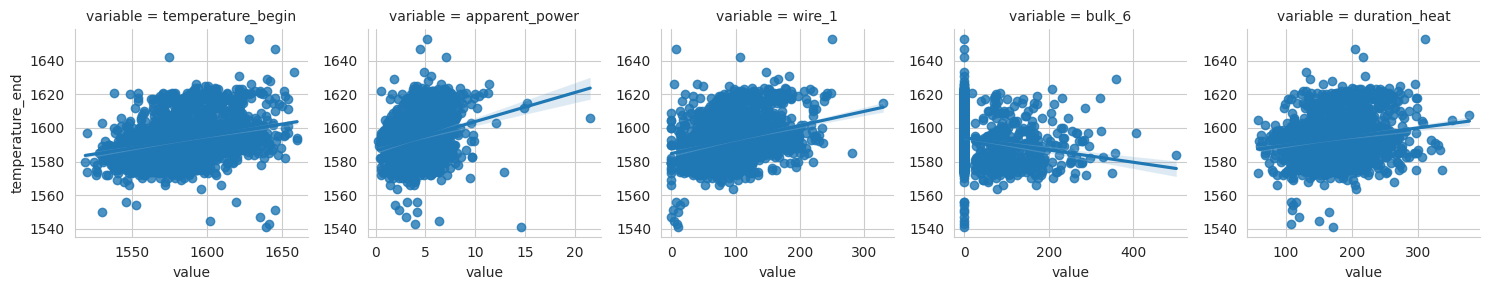

In [ ]:
f = pd.melt(df,
            id_vars=['temperature_end'],
            value_vars= fi.sort_values('w', ascending=False)[:5].name)


g = sns.FacetGrid(f, col="variable",
                  sharex=False,
                  sharey=False)

g = g.map(sns.regplot, "value", 'temperature_end')

### График предсказанной температуры

Сравним на графике предсказанное значение температуры с ревльным

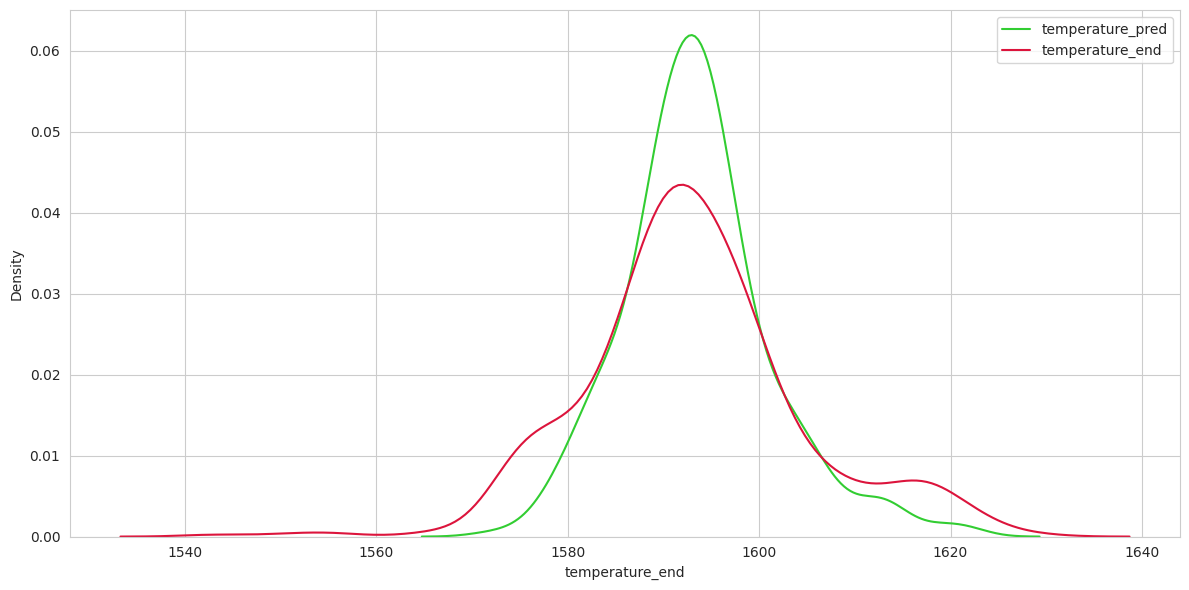

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.kdeplot(data=y_pred,
            color='limegreen', label='temperature_pred', ax=ax)

sns.kdeplot(data=y_test,
            color='crimson', label='temperature_end', ax=ax)
ax.legend()
plt.tight_layout()
plt.show()

На графике видно, что предсказанная температура повторяет реальное значение

## Вывод

1. Данные загружены из базы данных PostgreSQL. И сохранены в датафреймы.

2. Проведен исследовательский анализ данных в ходе которого:
    1. Аномалии в данных были заменены на медианные значения
    2. Дубликаты не были обнаружены
    3. Сгенерированны новые признаки
    4. Все таблицы объеденены одну в которой каждой партии соответствует одно наблюдение

3. Данные подгатовлены для обучения:<br>
    Разделены на 3 выборки, тренировочную, валидационную и тестовую, тестовая выборка составляет 25%

3. Обучено три модели:
    1. Случаный лес
    2. Catboost
    3. Нейронная сеть
    
  

4. Выбрана лучшая модель по средней абсолютной ошибке (MAE) -- CatBoost со значением MAE на валидационной выборке - 4.86


5. Тестирование лучшей модели

    1. Обученная модель CatBoost, проверена на тестовых данных и **ошибается на &pm; 5.92 &deg;C**
    2. Признаки оказывающее наибольшее влияние на приедсказание модели:
        1. temperature_begin
        2. apparent_power
        3. wire_1
        4. bulk_6
        5. duration_hea
    3. Для важных признаков построены графики зависимрсти от целевой переменной

**Рекомендации:**

1. Увеличить количество данных для обучения модели.
2. Получить у технологов данные о правильных диапазонах добавляемых материалов для более точной обработки аномалий